In [132]:
import numpy as np
import scipy as sp
import random
import matplotlib
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import GPy
from elfi.bo.gpy_model import GPyModel
from elfi.posteriors import BolfiPosterior
import matplotlib.gridspec as gridspec
from matplotlib import rc
%matplotlib inline

In [89]:
class Prior():

    def __init__(self, minval, maxval):
        self.minval = minval
        self.maxval = maxval

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getLogProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getRandomValue(self):
        raise NotImplementedError("Subclass implements")


class UniformPrior(Prior):
    """ Uniform distribution over the half-open interval [minval, maxval) """

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        return 1.0 / (self.maxval - self.minval)

    def getLogProbDensity(self, value):
        return np.log(1.0) - np.log(self.maxval - self.minval)

    def getRandomValue(self):
        return np.random.uniform(self.minval, self.maxval)


class ClippedNormalPrior(Prior):
    """ Normal distribution truncated to interval [minval, maxval] """

    def __init__(self, minval, maxval, mean, std):
        super(ClippedNormalPrior, self).__init__(minval, maxval)
        self.mean = mean
        self.std = std

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        if self.std <= 0.0:
            raise ValueError("Prior std (%.2f) must be positive" % (self.std))
        return True

    def getProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.pdf(value, a, b, self.mean, self.std)

    def getLogProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.logpdf(value, a, b, self.mean, self.std)

    def getRandomValue(self):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.rvs(a, b, self.mean, self.std)
    
def plot_2d_mesh(X, Y, Z, ax):
    """
        Plot 2D mesh data with 'nlevels' contours.
        http://stackoverflow.com/questions/5127668/how-to-visualize-scalar-2d-data-with-matplotlib
    """
    return ax.contourf(X, Y, Z, cmap='hot')
    
def plot_3d_mesh(X, Y, Z, fig):
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='hot', alpha=1.0, antialiased=True, cstride=1, rstride=1, linewidth=0)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-1, cmap='hot')
    #cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap='hot')
    #cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap='hot')
    #ax.set_xlabel('X')
    #ax.set_xlim(-40, 40)
    #ax.set_ylabel('Y')
    #ax.set_ylim(-40, 40)
    #ax.set_zlabel('Z')
    ax.set_zlim(-1, np.max(Z))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    pl.show()
    
def eval_2d_mesh(xmin, ymin, xmax, ymax, nx, ny, eval_fun):
    """
        Evaluate 'eval_fun' at a grid defined by max and min
        values with number of points defined by 'nx' and 'ny'.
    """
    if xmin > xmax:
        raise ValueError("xmin (%.2f) was greater than"
                         "xmax (%.2f)" % (xmin, xmax))
    if ymin > ymax:
        raise ValueError("ymin (%.2f) was greater than"
                         "ymax (%.2f)" % (xmin, xmax))
    if nx < 1 or ny < 1:
        raise ValueError("nx (%.2f) or ny (%.2f) was less than 1" % (nx, ny))
    X = np.linspace(xmin, xmax, nx)
    lenx = len(X)
    Y = np.linspace(ymin, ymax, ny)
    leny = len(Y)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((leny, lenx))
    for i in range(leny):
        for j in range(lenx):
            Z[i][j] = eval_fun([X[i][j], Y[i][j]])
    return (X, Y, Z)

(233, 2) (233, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.1921) as threshold


NameError: name 'j' is not defined

 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


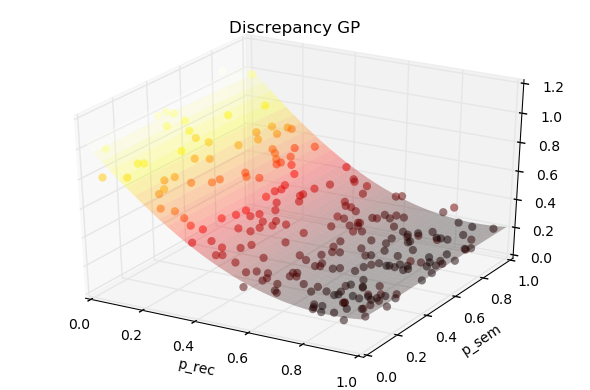

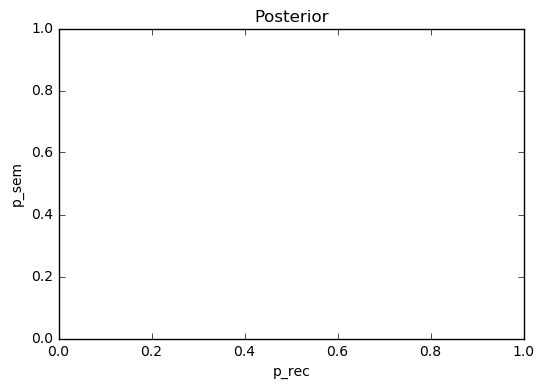

In [78]:
random.seed(0)
for i in range(6):
    params = [(ClippedNormalPrior(0, 6, 3, 1), (0,6), "f_dur"),
              (ClippedNormalPrior(0, 1, 0.3, 0.3), (0,1), "d_sel"),
              #(ClippedNormalPrior(0, 1, 0.69, 0.2), (0,1), "p_rec"),
              #(ClippedNormalPrior(0, 1, 0.93, 0.2), (0,1), "p_sem")]
              (UniformPrior(0, 1), (0,1), "p_rec"),
              (UniformPrior(0, 1), (0,1), "p_sem")]
    data, x_id, y_id = [(md5_f01_i23, 2, 3),
                        (md5_f02_i13, 1, 3),
                        (md5_f03_i12, 1, 2),
                        (md5_f12_i03, 0, 3),
                        (md5_f13_i02, 0, 2),
                        (md5_f23_i01, 0, 1)][i]
    priors = [params[x_id][0], params[y_id][0]]
    bounds = (params[x_id][1], params[y_id][1])
    name_x = params[x_id][2]
    name_y = params[y_id][2]
    X = list()
    Y = list()
    for y, x in data:
        X.append(x)
        Y.append(y)
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y).T
    print(X.shape, Y.shape)

    gp = GPyModel(
                  input_dim=X.shape[1],
                  bounds=bounds,
                  kernel_class=GPy.kern.RBF,
                  kernel_var=10.0,
                  kernel_scale=0.2,
                  noise_var=0.5,
                  max_opt_iters=100
                 )
    gp.update(X, Y)
    gp.gp.plot(plot_limits=[[bounds[0][0], bounds[1][0]], [bounds[0][1], bounds[1][1]]],
               projection="3d", legend=0)
    #pl.gca().legend().set_visible(False)
    pl.title("Discrepancy GP")
    pl.xlabel(name_x)
    pl.ylabel(name_y)

    fig = pl.figure()
    pl.title("Posterior")
    pl.xlabel(name_x)
    pl.ylabel(name_y)
    post = BolfiPosterior(model=gp, threshold=None, priors=priors)
    #print("ML at {}".format(post.ML))
    #pl.plot(post.ML[0], post.ML[1], "r*", markersize=20)
    #print("MAP at {}".format(post.MAP))
    #pl.plot(post.MAP[0], post.MAP[1], "g*", markersize=20)
    vals = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 100, 100, post.pdf)
    plot_2d_mesh(*vals)
    #plot_3d_mesh(*vals, fig=fig)

(313, 2) (313, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0011) as threshold


(320, 2) (320, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0007) as threshold


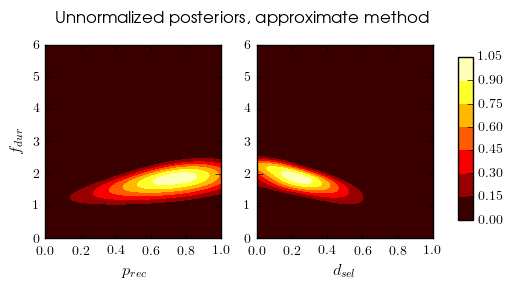

In [166]:
random.seed(0)
fig, axarr = pl.subplots(1, 2, figsize=(5,2.5))
pl.rc('text', usetex=True)
pl.rc('font', **{'family':'sans-serif','sans-serif':['Avant Garde']})
pl.suptitle(r"Unnormalized posteriors, approximate method", fontsize=12, x=0.52, y=1.04)
j = 0
for i in [4,5]:
    params = [(ClippedNormalPrior(0, 6, 3, 1), (0,6), r"$f_{dur}$"),
              (ClippedNormalPrior(0, 1, 0.3, 0.3), (0,1), r"$d_{sel}$"),
              #(ClippedNormalPrior(0, 1, 0.69, 0.2), (0,1), "p_rec"),
              #(ClippedNormalPrior(0, 1, 0.93, 0.2), (0,1), "p_sem")]
              (UniformPrior(0, 1), (0,1), r"$p_{rec}$"),
              (UniformPrior(0, 1), (0,1), r"$p_{sem}$")]
    data, x_id, y_id = [(md5_f01_i23, 2, 3),
                        (md5_f02_i13, 1, 3),
                        (md5_f03_i12, 1, 2),
                        (md5_f12_i03, 0, 3),
                        (md5_f13_i02, 0, 2),
                        (md5_f23_i01, 0, 1)][i]
    priors = [params[y_id][0], params[x_id][0]]
    bounds = (params[y_id][1], params[x_id][1])
    name_x = params[y_id][2]
    name_y = params[x_id][2]
    X = list()
    Y = list()
    for y, x in data:
        X.append([x[1], x[0]])
        Y.append(y)
    X = np.atleast_2d(X[:320])
    Y = np.atleast_2d(Y[:320]).T
    print(X.shape, Y.shape)

    gp = GPyModel(
                  input_dim=X.shape[1],
                  bounds=bounds,
                  kernel_class=GPy.kern.RBF,
                  kernel_var=10.0,
                  kernel_scale=0.2,
                  noise_var=0.5,
                  max_opt_iters=100
                 )
    gp.update(X, Y)

    ax = axarr[j]
    ax.set_xlabel(name_x, fontsize=12)
    if j == 0:
        ax.set_ylabel(name_y, fontsize=12)
    post = BolfiPosterior(model=gp, threshold=None, priors=priors)
    vals = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 100, 100, post.pdf)
    CS = ax.contourf(vals[0], vals[1], vals[2] / np.max(vals[2]), cmap='hot')
    j += 1
cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.65]) # left, bottom, width, height
fig.colorbar(CS, cax=cbar_ax)
#pl.tight_layout()
pl.show()
fig.savefig('../results/menu_posteriors.png', bbox_inches='tight')

 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


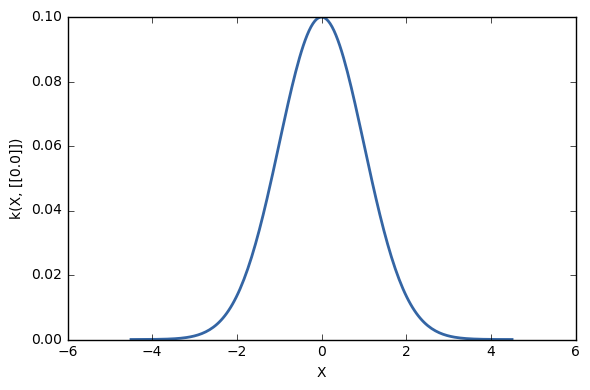

In [31]:
k1 = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=1)
k1.plot()

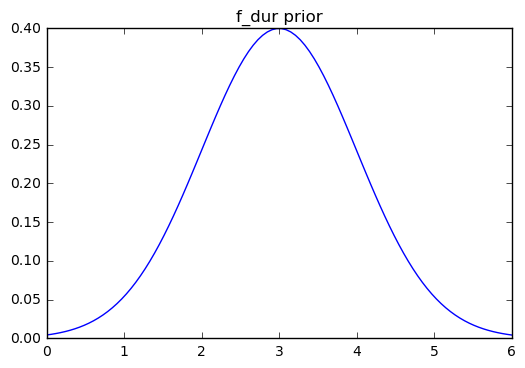

In [59]:
x = np.linspace(0, 6, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -3, 3, 3, 1))
pl.title("f_dur prior")
pl.show()

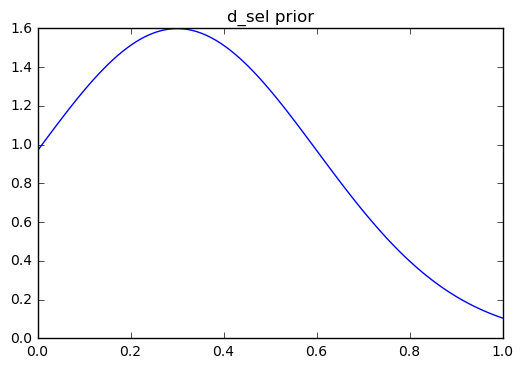

In [60]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -1, 0.7/0.3, 0.3, 0.3))
pl.title("d_sel prior")
pl.show()

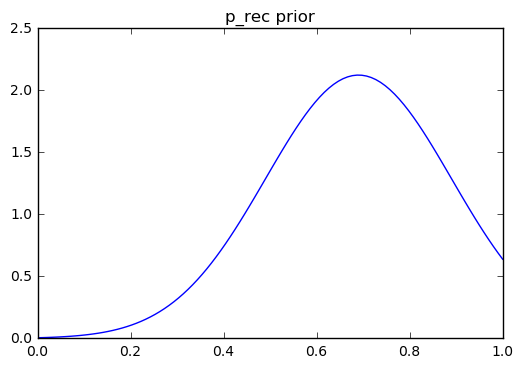

In [62]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -0.69/0.2, (1-0.69)/0.2, 0.69, 0.2))
pl.title("p_rec prior")
pl.show()

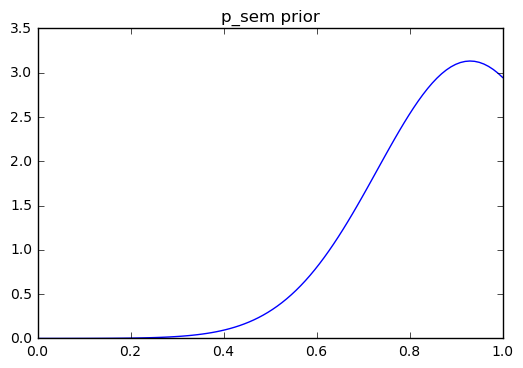

In [63]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -0.93/0.2, (1-0.93)/0.2, 0.93, 0.2))
pl.title("p_sem prior")
pl.show()

In [64]:
# md5_f01_i23 temp data
md5_f01_i23 = [(0.186956, (0.97944977, 0.78142745)),
(0.222320, (0.96375041, 0.81239668)),
(0.251466, (0.94032049, 0.50158359)),
(0.313806, (0.82360117, 0.95420041)),
(0.184266, (0.88298861, 0.48905022)),
(0.193589, (0.8970541, 0.49513162)),
(0.200478, (0.80304641, 0.84294375)),
(0.252706, (0.59568973, 0.80146682)),
(0.194880, (0.74891187, 0.60786036)),
(0.193771, (0.77807582, 0.7309121)),
(0.294377, (0.6039006, 0.9944358)),
(0.244777, (0.67254794, 0.03718277)),
(0.343028, (0.52778346, 0.34072547)),
(0.255613, (0.6183481, 0.54261463)),
(0.183308, (0.87089941, 0.82106358)),
(0.263635, (0.98874519, 0.03033131)),
(0.428204, (0.40053706, 0.49306278)),
(0.427571, (0.37466691, 0.13392622)),
(0.226160, (0.69506418, 0.16859963)),
(0.533108, (0.3823265, 0.46505361)),
(0.203882, (0.85590436, 0.2675318)),
(0.378502, (0.46949678, 0.22383228)),
(0.391210, (0.40082383, 0.85585263)),
(0.654938, (0.30686649, 0.65981935)),
(0.401856, (0.46570192, 0.9093363)),
(0.354748, (0.49301139, 0.08454193)),
(0.703903, (0.20670492, 0.90660738)),
(0.413374, (0.43324721, 0.33679012)),
(0.308421, (0.53654615, 0.07672753)),
(0.517350, (0.3341972, 0.7314692)),
(0.342288, (0.54244036, 0.74934603)),
(0.323283, (0.65272095, 0.56545441)),
(0.529929, (0.36436616, 0.21559242)),
(0.347019, (0.51253762, 0.88418018)),
(0.234195, (0.65519035, 0.47433997)),
(0.573560, (0.27379303, 0.81079427)),
(0.545501, (0.32674347, 0.08817913)),
(0.638383, (0.25948459, 0.73234289)),
(0.759725, (0.23226783, 0.08752966)),
(0.695323, (0.19297892, 0.11774913)),
(0.652144, (0.18889665, 0.31682458)),
(0.720382, (0.19976079, 0.72336849)),
(0.872250, (0.13098623, 0.13345483)),
(0.718343, (0.12201287, 0.44879198)),
(1.148885, (0.06603275, 0.7225176)),
(0.871573, (0.16716543, 0.29933502)),
(0.950319, (0.052903, 0.39560544)),
(0.826129, (0.12336134, 0.04489103)),
(0.871279, (0.07707669, 0.49158434)),
(0.989200, (0.0302708, 0.97015753)),
(0.626772, (0.23161791, 0.42406566)),
(0.675947, (0.30982626, 0.02522149)),
(1.020064, (0.07108831, 0.0094746)),
(0.654618, (0.1876877, 0.96560097)),
(0.816027, (0.04661746, 0.01901614)),
(0.994341, (0.03819406, 0.46211153)),
(0.865759, (0.14674278, 0.85993184)),
(0.562332, (0.23032014, 0.91265671)),
(0.702427, (0.14073313, 0.23204538)),
(0.747051, (0.19554631, 0.60449956)),
(0.805431, (0.08107861, 0.52369834)),
(0.198815, (0.81394652, 0.02000386)),
(0.168939, (0.95364865, 0.78685794)),
(0.470079, (0.34181362, 0.63309285)),
(0.260617, (0.59888317, 0.69628044)),
(0.292724, (0.90998235, 0.6683913)),
(0.237080, (0.60673224, 0.86837501)),
(0.290872, (0.60931329, 0.6904466)),
(0.397071, (0.45149853, 0.07441873)),
(0.638686, (0.22996195, 0.76607328)),
(0.409516, (0.42226951, 0.29715964)),
(0.509225, (0.35232546, 0.11961083)),
(0.585734, (0.29945358, 0.92934584)),
(0.672472, (0.25437341, 0.02892651)),
(0.642473, (0.23762192, 0.36567812)),
(0.242949, (0.67913094, 0.86927955)),
(0.605404, (0.31680938, 0.06731775)),
(0.192293, (0.82921221, 0.49392634)),
(0.199348, (0.98833609, 0.04505039)),
(0.460878, (0.42650732, 0.70549669)),
(0.181850, (0.98269402, 0.25286642)),
(0.188684, (0.99869677, 0.16681655)),
(0.187173, (0.85052259, 0.52670332)),
(0.207451, (0.96359002, 0.17766632)),
(0.199217, (0.77353336, 0.17791468)),
(0.210650, (0.80956457, 0.23828762)),
(0.181568, (0.87497865, 0.53445745)),
(0.202749, (0.72388498, 0.66327127)),
(0.190102, (0.79143646, 0.06732062)),
(0.164805, (0.78969065, 0.19953281)),
(0.236754, (0.63277733, 0.23461855)),
(0.263836, (0.56814988, 0.00754033)),
(0.295646, (0.60638071, 0.68202102)),
(0.243081, (0.92418482, 0.25403786)),
(0.351601, (0.555431, 0.63427318)),
(0.264181, (0.66177696, 0.84815732)),
(0.290182, (0.59338227, 0.31946667)),
(0.199840, (0.73240185, 0.15111074)),
(0.205515, (0.97808425, 0.57945596)),
(0.263358, (0.59003507, 0.08875247)),
(0.186695, (0.86656988, 0.13057728)),
(0.295442, (0.54560652, 0.69626956)),
(0.337631, (0.53676882, 0.1860025)),
(0.457076, (0.41832192, 0.62390858)),
(0.292893, (0.5514356, 0.11779634)),
(0.352372, (0.50408053, 0.77470632)),
(0.444787, (0.44754673, 0.07914247)),
(0.440998, (0.37508328, 0.54461464)),
(0.567428, (0.26876292, 0.72618473)),
(0.300463, (0.5915751, 0.97305583)),
(0.249396, (0.65945355, 0.30367888)),
(0.632579, (0.29835024, 0.48201831)),
(0.958198, (0.08028695, 0.462477)),
(0.779849, (0.1207302, 0.53956936)),
(0.870531, (0.09925263, 0.70045509)),
(0.178414, (0.97264783, 0.51827)),
(0.173527, (0.92697594, 0.57001607)),
(0.203465, (0.79582571, 0.48454748)),
(0.266133, (0.9766441, 0.16533143)),
(0.191401, (0.82418574, 0.66465365)),
(0.184660, (0.86023406, 0.13121113)),
(0.189106, (0.9354142, 0.21690359)),
(0.236473, (0.68953221, 0.78081779)),
(0.186277, (0.81647183, 0.34291521)),
(0.190131, (0.84942328, 0.49272995)),
(0.281898, (0.92277689, 0.02903969)),
(0.389419, (0.42857667, 0.07201069)),
(0.274664, (0.94834665, 0.1342618)),
(0.422546, (0.42032196, 0.61414003)),
(0.232293, (0.99898902, 0.22953491)),
(0.227655, (0.68408783, 0.63458044)),
(0.170101, (0.83174157, 0.04187133)),
(0.274130, (0.82645388, 0.6964348)),
(0.521066, (0.38564725, 0.33125067)),
(0.184141, (0.77008564, 0.73048063)),
(0.171382, (0.82378527, 0.8333506)),
(0.229638, (0.69447536, 0.54798332)),
(0.253602, (0.67701798, 0.30571408)),
(0.200787, (0.74447171, 0.77719676)),
(0.307672, (0.55200326, 0.76481619)),
(0.307804, (0.55563762, 0.59188586)),
(0.273960, (0.62248311, 0.30950788)),
(0.246073, (0.62663523, 0.21816576)),
(0.196707, (0.71344095, 0.72200658)),
(0.225611, (0.74623023, 0.17019616)),
(0.286688, (0.60701168, 0.08821033)),
(0.276119, (0.65985418, 0.41458148)),
(0.165689, (0.92483187, 0.71444585)),
(0.467802, (0.33098134, 0.60797054)),
(0.194872, (0.73149394, 0.54795718)),
(0.213878, (0.71532838, 0.36837413)),
(0.429647, (0.46973887, 0.35697529)),
(0.424051, (0.41891367, 0.38113201)),
(0.742878, (0.18584158, 0.83790058)),
(0.528559, (0.28624914, 0.79515096)),
(0.209143, (0.75999042, 0.74564336)),
(0.163058, (0.84381881, 0.22439962)),
(0.155943, (0.7988426, 0.53071385)),
(0.724879, (0.17053759, 0.46319946)),
(0.176606, (0.94215507, 0.25974971)),
(0.192917, (0.95255032, 0.61542967)),
(0.220219, (0.9661341, 0.11701102)),
(0.174780, (0.87875619, 0.98597051)),
(0.180659, (0.93448002, 0.00424201)),
(0.156630, (0.96373348, 0.46723067)),
(0.298842, (0.93472317, 0.4397697)),
(0.186122, (0.95558016, 0.57768222)),
(0.194717, (0.93013625, 0.1882331)),
(0.178043, (0.98366075, 0.65842295)),
(0.188183, (0.88057307, 0.03763471)),
(0.177159, (0.8059161, 0.1976146)),
(0.170649, (0.8934613, 0.23553633)),
(0.227631, (0.73750679, 0.4974864)),
(0.193304, (0.76389034, 0.43920122)),
(0.159870, (0.88388675, 0.66734112)),
(0.183820, (0.89536505, 0.88748034)),
(0.332099, (0.51311096, 0.76489868)),
(0.270307, (0.66950598, 0.1666053)),
(0.362297, (0.54668894, 0.42549545)),
(0.377110, (0.41988341, 0.46396384)),
(0.514051, (0.3753156, 0.28628398)),
(0.393590, (0.47782483, 0.43005454)),
(0.176296, (0.82055884, 0.99859027)),
(0.359284, (0.44053171, 0.20377182)),
(0.439261, (0.39520494, 0.26654403)),
(0.556286, (0.26285406, 0.76428941)),
(0.473237, (0.40755969, 0.37968011)),
(0.276132, (0.638125, 0.4618998)),
(0.269757, (0.64249315, 0.64550097)),
(0.424539, (0.39629499, 0.68209717)),
(0.474903, (0.41854593, 0.93659832)),
(0.351904, (0.41508369, 0.9946546)),
(0.699643, (0.13821396, 0.81550772)),
(0.474917, (0.33358986, 0.67016966)),
(0.865390, (0.11004957, 0.12914679)),
(0.699367, (0.20658634, 0.83570655)),
(0.168234, (0.87530177, 0.20938487)),
(0.236585, (0.76446985, 0.99128914)),
(0.225465, (0.99367957, 0.7137015)),
(0.203865, (0.69124706, 0.36384477)),
(0.184208, (0.8477554, 0.28224399)),
(0.170125, (0.79253647, 0.30322552)),
(0.442032, (0.33952153, 0.07371069)),
(0.174013, (0.93152059, 0.12549807)),
(0.265170, (0.57555827, 0.68148834)),
(0.253360, (0.62732404, 0.40167399)),
(0.185445, (0.75832605, 0.82457668)),
(0.172511, (0.8098535, 0.08741789)),
(0.246298, (0.66375095, 0.3413838)),
(0.197711, (0.71503559, 0.79833802)),
(0.241869, (0.6418991, 0.83917391)),
(0.182495, (0.92149301, 0.59933601)),
(0.186692, (0.80643455, 0.21307006)),
(0.195093, (0.80592768, 0.03987439)),
(0.184107, (0.95474818, 0.99328502)),
(0.452811, (0.3773678, 0.37217257)),
(0.204574, (0.7647541, 0.38015376)),
(0.575910, (0.29784809, 0.56471471)),
(0.382773, (0.51102081, 0.91442028)),
(0.272102, (0.57672612, 0.1451961)),
(0.203810, (0.81627617, 0.57440243)),
(0.224178, (0.64393292, 0.07408413)),
(0.254226, (0.63971239, 0.17635981)),
(0.293680, (0.63861291, 0.7544772)),
(1.129565, (0.04864773, 0.75214887)),
(0.577579, (0.23139489, 0.58577184)),
(1.040251, (0.04640854, 0.35534889)),
(0.728387, (0.17244759, 0.24527728)),
(0.996432, (0.00963199, 0.45980128)),
(0.175034, (0.84132332, 0.83041634)),
(0.250283, (0.63769232, 0.10068571)),
(0.176326, (0.89097126, 0.10041857)),
(0.217292, (0.78985018, 0.44278685))]

In [65]:
md5_f02_i13 = [(0.699321, (0.79464944, 0.28369539)),
(0.244591, (0.31766998, 0.02607214)),
(0.459667, (0.57913423, 0.78428342)),
(0.690026, (0.76433382, 0.68380493)),
(0.104223, (0.05153425, 0.9396372)),
(0.693690, (0.79621666, 0.41512935)),
(0.647899, (0.78133792, 0.19094984)),
(0.202368, (0.23738806, 0.2734136)),
(0.368855, (0.47835416, 0.23544343)),
(0.618745, (0.71300026, 0.07567231)),
(0.277403, (0.383928, 0.93468796)),
(0.624574, (0.72780102, 0.96020549)),
(0.151966, (0.14417709, 0.07203921)),
(0.133846, (0.12397473, 0.57525566)),
(0.136890, (0.06423516, 0.89606703)),
(0.685847, (0.80565512, 0.27855733)),
(0.147603, (0.0741736, 0.62601533)),
(0.405453, (0.53268125, 0.61605974)),
(0.776742, (0.88997281, 0.10633359)),
(0.123163, (0.11216366, 0.25844824)),
(0.525462, (0.66245823, 0.16476525)),
(0.806983, (0.8231705, 0.66750815)),
(0.292847, (0.36721325, 0.47626483)),
(0.114168, (0.07049657, 0.84654181)),
(0.472286, (0.62431581, 0.8245247)),
(0.833123, (0.89529653, 0.51757133)),
(0.268334, (0.35489745, 0.20846621)),
(0.683027, (0.77712012, 0.91401781)),
(0.508861, (0.62211072, 0.43807423)),
(0.565626, (0.68615744, 0.80525463)),
(0.190335, (0.23585554, 0.30171678)),
(0.462564, (0.59227106, 0.6475477)),
(0.528576, (0.67221874, 0.84801821)),
(0.955776, (0.95975928, 0.79763781)),
(0.163314, (0.22288162, 0.69177777)),
(0.683076, (0.80102576, 0.98083166)),
(1.016867, (0.99646226, 0.82468942)),
(0.880768, (0.93526731, 0.89876149)),
(0.850325, (0.86903524, 0.59424036)),
(0.660015, (0.73844909, 0.22186771)),
(0.110026, (0.10268359, 0.10633749)),
(0.248149, (0.32529828, 0.72019639)),
(0.102217, (0.07909818, 0.99467545)),
(0.446668, (0.55215245, 0.96021043)),
(0.969881, (0.99922041, 0.41530178)),
(0.156518, (0.12613178, 0.27930725)),
(0.115182, (0.0017265, 0.09553347)),
(0.741916, (0.84192898, 0.72754427)),
(0.467678, (0.62082087, 0.40516178)),
(0.527207, (0.63302007, 0.70387047)),
(0.100423, (0.07539983, 0.18025986)),
(0.213266, (0.27110336, 0.09864099)),
(0.182981, (0.23312855, 0.98738741)),
(0.272195, (0.35367298, 0.85802824)),
(0.225381, (0.30532727, 0.80707686)),
(0.256387, (0.37264058, 0.8735497)),
(0.239884, (0.33157096, 0.80963404)),
(0.309784, (0.3917843, 0.02380307)),
(0.366491, (0.47801104, 0.12715812)),
(0.594549, (0.72635636, 0.72476085)),
(0.900710, (0.94963068, 0.63924444)),
(0.482567, (0.6162813, 0.20410925)),
(0.261373, (0.32209291, 0.67273077)),
(0.636145, (0.70093936, 0.65039623)),
(0.672515, (0.77875406, 0.17738243)),
(0.110413, (0.07794989, 0.26820501)),
(0.116548, (0.09618137, 0.37965311)),
(0.369820, (0.51579734, 0.64213504)),
(0.562200, (0.70278194, 0.33158849)),
(0.842335, (0.88833977, 0.58729067)),
(0.659372, (0.74986941, 0.67154277)),
(0.705127, (0.82742123, 0.26132788)),
(0.279138, (0.38400051, 0.5964537)),
(0.147146, (0.18202707, 0.18837342)),
(0.154398, (0.08518979, 0.05045137)),
(0.351389, (0.46701581, 0.6793374)),
(0.248302, (0.33250525, 0.16930548)),
(0.086175, (0.00697002, 0.6074379)),
(0.130968, (0.12806308, 0.52816431)),
(0.109441, (0.06082696, 0.05627044)),
(0.137127, (0.13220178, 0.62645049)),
(0.187914, (0.1778355, 0.38348064)),
(0.104851, (0.04383931, 0.78951594)),
(0.163016, (0.18065513, 0.22280532)),
(0.079157, (0.02421907, 0.14805042)),
(0.134690, (0.15302353, 0.63348749)),
(0.274229, (0.39448612, 0.49138598)),
(0.121453, (0.08433781, 0.53723683)),
(0.176598, (0.21032166, 0.96099315)),
(0.195195, (0.23983138, 0.5640391)),
(0.152673, (0.13501937, 0.4547662)),
(0.236018, (0.29780457, 0.52638097)),
(0.304123, (0.3031997, 0.47806933)),
(0.198732, (0.20373565, 0.29470401)),
(0.199659, (0.22061391, 0.70052759)),
(0.135657, (0.0995544, 0.38196227)),
(0.079051, (0.00267531, 0.85727946)),
(0.182524, (0.26085819, 0.61925453)),
(0.114647, (0.08897489, 0.08644328)),
(0.126099, (0.12336051, 0.66937756)),
(0.194031, (0.2703703, 0.79649812)),
(0.148955, (0.11262508, 0.71047277)),
(0.104635, (0.00180541, 0.26838779)),
(0.132382, (0.03603987, 0.79945391)),
(0.098981, (0.03206664, 0.36684152)),
(0.130881, (0.1024523, 0.76104703)),
(0.081959, (0.02178096, 0.26478112)),
(0.291217, (0.4089654, 0.0278364)),
(0.162088, (0.13624344, 0.39239724)),
(0.128869, (0.13620555, 0.06955645)),
(0.201914, (0.22535325, 0.01073652)),
(0.131349, (0.1194662, 0.47216517)),
(0.090150, (0.00066852, 0.49840813)),
(0.237934, (0.2875526, 0.42753766)),
(0.182475, (0.24949138, 0.14568319)),
(0.128553, (0.05720923, 0.5646609)),
(0.126846, (0.08106857, 0.24673912)),
(0.177893, (0.21818203, 0.22975173)),
(0.101423, (0.03299189, 0.15579211)),
(0.108656, (0.00111166, 0.47353249)),
(0.115861, (0.06963053, 0.13795915)),
(0.220822, (0.23613914, 0.02007786)),
(0.286237, (0.35402428, 0.64842888)),
(0.159163, (0.17290427, 0.46930142)),
(0.131788, (0.09797553, 0.9744006)),
(0.347230, (0.46541289, 0.38619685)),
(0.129848, (0.09798598, 0.3530156)),
(0.406971, (0.52516375, 0.57759412)),
(0.280433, (0.35563386, 0.14033366)),
(0.120499, (0.08170752, 0.37949422)),
(0.155060, (0.13881874, 0.21437423)),
(0.085732, (0.00757963, 0.82793703)),
(0.210711, (0.0402114, 0.99636877)),
(0.199287, (0.23368916, 0.10035017)),
(0.150973, (0.07564422, 0.55522963)),
(0.081908, (0.06419294, 0.4497756)),
(0.391485, (0.45438854, 0.08735987)),
(0.266043, (0.18371357, 0.26724245)),
(0.145565, (0.14785266, 0.20404365)),
(0.164777, (0.18882814, 0.66666537)),
(0.264613, (0.357011, 0.04042918)),
(0.224531, (0.30654081, 0.89586343)),
(0.200263, (0.31699579, 0.25477021)),
(0.182573, (0.2424995, 0.05818205)),
(0.333400, (0.11911207, 0.8104321)),
(0.217457, (0.3307974, 0.71775758)),
(0.284436, (0.33933364, 0.04649611)),
(0.100138, (0.06131901, 0.25594027)),
(0.153847, (0.15456538, 0.9056295)),
(0.094451, (6.66625398e-04, 7.28417936e-01)),
(0.111685, (0.07672965, 0.2318095)),
(0.516024, (0.61961066, 0.64252401)),
(0.100820, (0.11374831, 0.28150741)),
(0.133771, (0.14212406, 0.18195153)),
(0.093167, (0.03208921, 0.43249127)),
(0.255981, (0.33885131, 0.87708052)),
(0.170949, (0.11996538, 0.12640259)),
(0.095375, (0.01256468, 0.70153411)),
(0.153345, (0.08724286, 0.99505589)),
(0.122022, (0.01939794, 0.62169863)),
(0.235919, (0.31966749, 0.57068782)),
(0.075443, (0.00172226, 0.51592963)),
(0.140687, (0.16603498, 0.1124784)),
(0.062569, (0.00915153, 0.96888003)),
(0.107909, (0.00278058, 0.26572723)),
(0.174769, (0.26524393, 0.03222251)),
(0.140266, (0.12673756, 0.20374638)),
(0.084685, (0.01325659, 0.0347867)),
(0.180221, (0.22892575, 0.0201689)),
(0.129587, (0.09913645, 0.646074)),
(0.105122, (0.01677669, 0.27528302)),
(0.127634, (0.11207967, 0.09609822)),
(0.244385, (0.24899847, 0.47303793)),
(0.166668, (0.20033708, 0.17879309)),
(0.097991, (0.0463215, 0.98926709)),
(0.140393, (0.04756072, 0.06555514)),
(0.108975, (0.12178672, 0.44792889)),
(0.167808, (0.22291788, 0.96888598)),
(0.137235, (0.12222316, 0.01746731)),
(0.155941, (0.13664116, 0.39925844)),
(0.185625, (0.13627653, 0.5541948)),
(0.132857, (0.1538919, 0.38010131)),
(0.114756, (0.10302989, 0.80688028)),
(0.152249, (0.18499123, 0.52583706)),
(0.263920, (0.32384935, 0.52702435)),
(0.253873, (0.34584233, 0.11925036)),
(0.099391, (0.06509927, 0.50095253)),
(0.325982, (0.45089764, 0.48012833)),
(0.298905, (0.37045671, 0.89196141)),
(0.234479, (0.02633289, 0.3183107)),
(0.130599, (0.11411321, 0.62490323)),
(0.142901, (0.21002701, 0.21953742)),
(0.107751, (0.04342227, 0.39771784)),
(0.103640, (0.05464479, 0.83239374)),
(0.127763, (0.07786036, 0.67185696)),
(0.220137, (0.2726599, 0.11390415)),
(0.121130, (0.06085157, 0.36419164)),
(0.123924, (0.04020229, 0.39102337)),
(0.115518, (0.07760394, 0.69099718)),
(0.203960, (0.07840259, 0.96232331)),
(0.139122, (0.13202505, 0.42238114)),
(0.111717, (0.09753813, 0.74119729)),
(0.187657, (0.24485985, 0.49746908)),
(0.069834, (0.01522503, 0.92896187)),
(0.224675, (0.20282632, 0.36038721)),
(0.139898, (0.1074939, 0.53001209)),
(0.119410, (0.11101934, 0.19206915)),
(0.290001, (0.33911023, 0.16134582)),
(0.174981, (0.18813444, 0.67388894)),
(0.132719, (0.10685632, 0.2616868)),
(0.105206, (0.08864859, 0.50338179)),
(0.156610, (0.10858279, 0.8070555)),
(0.138280, (0.10116776, 0.76846696)),
(0.105409, (0.06542473, 0.01903254)),
(0.136356, (0.12347696, 0.58759764)),
(0.209262, (0.22783457, 0.83762016)),
(0.235689, (0.23692668, 0.30737172)),
(0.104929, (0.03238037, 0.47143928)),
(0.133107, (0.12799792, 0.95627773)),
(0.098671, (0.00271391, 0.33567388)),
(0.151476, (0.17121327, 0.07630723)),
(0.085028, (0.04919894, 0.47356623)),
(0.124238, (0.10341584, 0.2184367)),
(0.146181, (0.20033681, 0.29029517)),
(0.159665, (0.1286185, 0.52657268)),
(0.146459, (0.10618737, 0.81058921)),
(0.092785, (0.02237099, 0.10810354)),
(0.198000, (0.24409687, 0.13189588)),
(0.147988, (0.13510073, 0.24265869)),
(0.301600, (0.37137086, 0.03953028)),
(0.157826, (0.15778941, 0.51752261)),
(0.214248, (0.25530483, 0.76976884)),
(0.271497, (0.36747549, 0.08068964)),
(0.144814, (0.18524179, 0.13026993)),
(0.143983, (0.20153612, 0.16511773)),
(0.120644, (0.01233607, 0.67297553)),
(0.137226, (0.13221973, 0.3031799)),
(0.118730, (0.01610092, 0.10246336)),
(0.227703, (0.31508655, 0.6217041)),
(0.222199, (0.28533227, 0.66536352))]

In [66]:
md5_f03_i12 = [(0.172833, (0.26370396, 0.94884689)),
(0.467528, (0.62077766, 0.95052047)),
(0.871117, (0.99162717, 0.92703837)),
(0.075743, (0.05614883, 0.99047801)),
(0.627959, (0.68924288, 0.90255093)),
(1.087407, (0.97439511, 0.83711534)),
(0.540705, (0.76682243, 0.87031652)),
(0.797578, (0.8347213, 0.94083303)),
(0.175845, (0.14224239, 0.65699913)),
(0.080564, (0.06225786, 0.78131173)),
(0.607048, (0.74989814, 0.8975487)),
(0.248598, (0.39143117, 0.80779141)),
(0.495908, (0.63061498, 0.65424453)),
(0.731927, (0.83728774, 0.686909)),
(0.090594, (0.13081995, 0.76141305)),
(0.951837, (0.97111892, 0.709417)),
(0.265223, (0.42374369, 0.89829836)),
(0.385947, (0.17475121, 0.34088269)),
(0.957911, (0.94472987, 0.67705211)),
(0.224166, (0.0458492, 0.5395544)),
(0.662301, (0.49113034, 0.43256625)),
(0.150405, (0.07513269, 0.60351787)),
(0.426998, (0.44063027, 0.58040147)),
(0.415821, (0.41048348, 0.5368299)),
(0.601999, (0.70438861, 0.63958175)),
(0.213360, (0.01772261, 0.53968265)),
(1.127404, (0.99247915, 0.53675392)),
(0.689085, (0.53534114, 0.38944046)),
(0.499903, (0.67797661, 0.84324686)),
(0.333021, (0.03762957, 0.3625169)),
(0.399103, (0.21942466, 0.36119293)),
(1.021738, (0.81997606, 0.36056134)),
(0.649083, (0.49959447, 0.38216333)),
(0.609041, (0.51573478, 0.40831499)),
(0.402498, (0.47656023, 0.62304566)),
(0.477902, (0.34835122, 0.43008918)),
(1.241002, (0.95320226, 0.35869644)),
(0.905710, (0.60037392, 0.27030919)),
(1.111744, (0.8197276, 0.33014434)),
(0.184626, (0.1111679, 0.59090021)),
(1.446652, (0.95785991, 0.23421369)),
(0.584165, (0.47488393, 0.44253946)),
(1.034728, (0.53919503, 0.05242797)),
(0.562545, (0.33068228, 0.33424899)),
(1.026633, (0.6701395, 0.28521417)),
(0.503323, (0.17118932, 0.28069666)),
(0.572935, (0.05903664, 0.26858133)),
(0.806442, (0.43288, 0.14154268)),
(0.574053, (0.16476784, 0.20523222)),
(0.494433, (0.01471994, 0.27662158)),
(0.956174, (0.04756391, 0.00358387)),
(0.580601, (0.13232957, 0.26195891)),
(0.574878, (0.629843, 0.59738252)),
(0.676703, (0.24027198, 0.17933446)),
(0.926353, (0.7160017, 0.35753881)),
(0.938936, (0.38545744, 0.1325333)),
(1.175712, (0.74716558, 0.1402719)),
(0.924771, (0.10214008, 0.03793122)),
(0.985793, (0.64614245, 0.24637877)),
(1.699229, (0.99013794, 0.15475808)),
(1.094447, (0.80121227, 0.27376986)),
(1.550139, (0.95919066, 0.10176255)),
(1.132577, (0.54112967, 0.07152351)),
(1.104698, (0.56204911, 0.1131724)),
(1.664418, (0.94152281, 0.15524786)),
(1.633970, (0.85893574, 0.01982602)),
(1.917472, (0.9409919, 0.00944787)),
(1.054266, (0.36417541, 0.10010289)),
(0.964223, (0.20290078, 0.06741513)),
(1.420011, (0.7978771, 0.13312713)),
(0.944199, (0.1818069, 0.06519038)),
(1.199480, (0.71338082, 0.20680007)),
(1.145663, (0.57979005, 0.10991366)),
(1.576223, (0.85023439, 0.09367905)),
(1.058960, (0.57821866, 0.1274791)),
(0.880066, (0.04924553, 0.01972515)),
(0.738371, (0.82908661, 0.68006532)),
(0.136853, (0.21994297, 0.78187478)),
(0.525291, (0.10452893, 0.27995356)),
(0.421084, (0.55926577, 0.73532753)),
(0.068018, (0.04801367, 0.97119976)),
(0.110356, (0.14251104, 0.99137516)),
(0.075872, (0.09322703, 0.86174289)),
(0.065328, (0.0606376, 0.91707291)),
(0.130333, (0.09291949, 0.92188833)),
(0.082830, (0.09344684, 0.85342874)),
(0.085410, (0.09254371, 0.81557745)),
(0.068627, (0.04756523, 0.83261609)),
(0.336338, (0.16701336, 0.86809995)),
(0.087768, (0.05277805, 0.93403426)),
(0.077810, (0.08137682, 0.74426262)),
(0.124581, (0.06945901, 0.6751718)),
(0.283867, (0.15835478, 0.47544878)),
(0.241485, (0.12890798, 0.55350861)),
(0.330894, (0.40955141, 0.66369677)),
(0.221579, (0.20696691, 0.58531143)),
(0.127152, (0.16814017, 0.67624608)),
(0.232048, (0.04085088, 0.514903)),
(0.158479, (0.04165288, 0.56542371)),
(0.238227, (0.01048721, 0.50235891)),
(0.163696, (0.11041764, 0.65041022)),
(0.184677, (0.06931303, 0.55092187)),
(0.209868, (0.0772539, 0.56022414)),
(0.339574, (0.08631157, 0.42471253)),
(0.218307, (0.18070682, 0.57854819)),
(0.116744, (0.11460051, 0.6920451)),
(0.317961, (0.33034998, 0.54080974)),
(0.410773, (0.10976891, 0.37813223)),
(0.628667, (0.23783352, 0.42829314)),
(0.371681, (0.15854995, 0.38692651)),
(0.538434, (0.1241388, 0.33030752)),
(0.446688, (0.04415424, 0.26449314)),
(0.719406, (0.40998267, 0.20615808)),
(0.642104, (0.12035655, 0.21505724)),
(0.786538, (0.16651606, 0.1590011)),
(0.587484, (0.03076964, 0.27705334)),
(0.613124, (0.29992138, 0.18685497)),
(0.619683, (0.03609426, 0.1882998)),
(0.764520, (0.01087979, 0.08670231)),
(0.461699, (0.03098774, 0.33731583)),
(0.356458, (0.06149812, 0.38301327)),
(0.174446, (0.2826664, 0.83317405)),
(0.252807, (0.32504427, 0.67534927)),
(0.206144, (0.27823769, 0.70386874)),
(0.077987, (0.03765614, 0.89558105)),
(0.081094, (0.07841776, 0.98562229)),
(0.225369, (0.01598084, 0.54448372)),
(0.094301, (0.13524175, 0.91551516)),
(0.143538, (0.17923559, 0.72122992)),
(0.124469, (0.14269974, 0.95229241)),
(0.162453, (0.20524597, 0.69731591)),
(0.248811, (0.31315016, 0.98276744)),
(0.191197, (0.01047259, 0.5421849)),
(0.272526, (0.29071716, 0.94241333)),
(0.178665, (0.18091168, 0.71436733)),
(0.115378, (0.14266211, 0.74539994)),
(0.259104, (0.31260614, 0.74141914)),
(0.153901, (0.24142799, 0.99528132)),
(0.185154, (0.03083198, 0.50481702)),
(0.044103, (0.01512447, 0.90847636)),
(0.181471, (0.05898467, 0.57502698)),
(0.355887, (1.57319348e-04, 3.53263196e-01)),
(0.056707, (0.03775722, 0.94746702)),
(0.381675, (0.10747688, 0.36113524)),
(0.098509, (0.0567404, 0.68096461)),
(0.286657, (0.35787161, 0.72099445)),
(0.860491, (0.02260152, 0.01513004)),
(0.176010, (0.31073682, 0.78032705)),
(0.769574, (0.37208346, 0.19639886)),
(0.528942, (0.02445919, 0.25154766)),
(0.508004, (0.32959234, 0.32880673)),
(0.119234, (0.06510586, 0.63842072)),
(0.105812, (0.09025063, 0.74356727)),
(0.423267, (0.06756191, 0.26908574)),
(0.350913, (0.14687662, 0.45218756)),
(0.957180, (0.20598919, 0.01638972)),
(0.076025, (0.04813684, 0.88062654)),
(0.159391, (0.26812503, 0.86635443)),
(0.112825, (0.17846527, 0.77199343)),
(0.197784, (0.09695418, 0.57652992)),
(0.063704, (0.03599633, 0.94759449)),
(0.105084, (0.14190996, 0.91470388)),
(0.111039, (0.142725, 0.90907787)),
(0.046240, (0.03785003, 0.92403866)),
(0.067604, (0.06090445, 0.96606504)),
(0.069521, (0.07347514, 0.93952261)),
(0.122711, (0.14851604, 0.69169943)),
(0.153580, (0.14911912, 0.72664467)),
(0.110686, (0.18352995, 0.95169214)),
(0.163394, (0.27162567, 0.86631831)),
(0.097972, (0.14271042, 0.86196055)),
(0.122190, (0.14614052, 0.79801871)),
(0.273795, (0.16435413, 0.4685279)),
(0.092739, (0.04909042, 0.67436102)),
(0.270085, (0.33676581, 0.65945714)),
(0.169280, (0.16422466, 0.65426916)),
(0.151688, (0.10246505, 0.65180446)),
(0.169706, (0.13699757, 0.64670895)),
(0.212688, (0.00992758, 0.54163121)),
(0.151094, (0.17718014, 0.7021321)),
(0.307264, (0.1665436, 0.48075742)),
(0.193968, (0.25485272, 0.75597094)),
(0.319929, (0.20201167, 0.4682699)),
(0.258530, (0.05899447, 0.43038542)),
(0.227627, (0.16138506, 0.55285531)),
(0.463882, (0.10987126, 0.2779094)),
(0.127406, (0.12366039, 0.72302273)),
(0.355746, (0.16502592, 0.47272139)),
(0.303135, (0.01226947, 0.4186804)),
(0.449817, (0.07154403, 0.36006789)),
(0.355203, (0.06095401, 0.34017607)),
(0.519244, (0.11657925, 0.27567328)),
(0.396116, (0.00812619, 0.34580024)),
(0.590300, (0.08594429, 0.19886221)),
(0.367411, (0.00271286, 0.34135231)),
(0.418938, (0.03492651, 0.32498929)),
(0.948722, (0.50625587, 0.10846911)),
(0.733955, (0.2006477, 0.04025435)),
(0.133911, (0.11310952, 0.68834585)),
(0.082799, (0.00148986, 0.73405377)),
(0.142791, (0.09711776, 0.9813463)),
(0.196835, (0.01142911, 0.5463556)),
(0.147222, (0.08642959, 0.63771407)),
(0.498776, (0.2464237, 0.28224717)),
(0.120221, (0.18671208, 0.84220854)),
(0.149685, (0.09922265, 0.67675686)),
(0.248591, (0.04953767, 0.48765532)),
(0.180143, (0.15137928, 0.66307207)),
(0.118823, (0.16345267, 0.78843511)),
(0.842012, (0.10103687, 0.1216248)),
(0.066688, (0.07462271, 0.89687737)),
(0.187109, (0.04657887, 0.58694233)),
(0.257726, (0.04452, 0.47962002)),
(0.127342, (0.16858167, 0.98742464)),
(0.091099, (0.03362437, 0.75515379)),
(0.252402, (0.27367793, 0.64318068)),
(0.329668, (0.06244785, 0.38999968)),
(0.170138, (0.0865025, 0.54070576)),
(0.533429, (0.02839725, 0.26678175)),
(0.137964, (0.13812112, 0.66822185)),
(0.062932, (0.00528108, 0.74221542)),
(0.521476, (0.0621735, 0.32718239)),
(0.858884, (0.11397358, 0.09843219)),
(0.333224, (0.10017907, 0.46303091)),
(1.041623, (0.10359579, 0.01068108)),
(0.337635, (0.46990095, 0.71958143)),
(0.881875, (0.02594482, 0.04622192)),
(0.241381, (0.03082156, 0.54046709)),
(0.578173, (0.10341969, 0.26961797)),
(0.289437, (0.25248638, 0.55423181)),
(0.117207, (0.07128555, 0.69815251))]

In [67]:
md5_f12_i03 = [(2.965358, (5.85716248, 0.22577731)),
(2.306986, (5.3981714, 0.03522065)),
(2.579639, (5.50750321, 0.62069117)),
(2.101102, (5.2548104, 0.64482625)),
(1.431828, (4.61918747, 0.78815559)),
(1.740344, (4.79314017, 0.844863)),
(2.215866, (5.26801664, 0.49746607)),
(2.152157, (5.12105238, 0.26110939)),
(2.359466, (5.43076643, 0.3320927)),
(2.865464, (5.76342952, 0.18833817)),
(0.000621, (1.67520731, 0.20538571)),
(0.106262, (0.91452117, 0.73288618)),
(0.333380, (2.95927821, 0.75258336)),
(1.407511, (4.54599041, 0.48239334)),
(2.975127, (5.81160607, 0.65267473)),
(0.065043, (2.31377329, 0.61473126)),
(0.091027, (0.92959633, 0.72889108)),
(2.693684, (5.70172395, 0.84504536)),
(1.025586, (4.08760617, 0.7837583)),
(0.690180, (3.64629222, 0.13019893)),
(0.775261, (3.72198048, 0.52657118)),
(1.566788, (4.70855685, 0.57338623)),
(1.527412, (4.65356419, 0.4699257)),
(0.497326, (3.4105905, 0.23689444)),
(0.001732, (1.58810281, 0.37457753)),
(0.051860, (1.08579014, 0.72270512)),
(0.891043, (3.85250182, 0.92282064)),
(0.838940, (3.89238073, 0.40398203)),
(1.007401, (4.11973104, 0.28319332)),
(0.667193, (3.57052868, 0.68685789)),
(0.265805, (2.89544168, 0.72475844)),
(0.285328, (0.39643829, 0.79773206)),
(2.828199, (5.72468237, 0.22235403)),
(2.969844, (5.89177116, 0.7270286)),
(0.018577, (1.34228116, 0.40252906)),
(0.105299, (2.42838084, 0.10831518)),
(0.033408, (1.22442973, 0.63216454)),
(0.165467, (0.72198731, 0.31428969)),
(0.844931, (3.9044986, 0.38211125)),
(0.352317, (0.25764613, 0.63379261)),
(2.514975, (5.53852459, 0.14713727)),
(2.020933, (5.1082382, 0.5559884)),
(0.431211, (3.24319065, 0.29264951)),
(0.179254, (2.73978383, 0.54096987)),
(0.178275, (2.69323776, 0.07748883)),
(0.085427, (0.98228662, 0.20140325)),
(0.059673, (2.30349759, 0.88969074)),
(0.150357, (0.70668828, 0.61829222)),
(0.061014, (2.2655254, 0.03869343)),
(0.001908, (1.61967515, 0.68903909)),
(0.370830, (0.15013897, 0.14852635)),
(0.341179, (0.25626189, 0.05949156)),
(0.112375, (0.85223138, 0.82718708)),
(0.075570, (2.31154759, 0.14787972)),
(1.388152, (4.6297111, 0.86677328)),
(0.384324, (0.1957804, 0.50296957)),
(0.007229, (1.44131452, 0.4893951)),
(0.250744, (0.45478764, 0.85779067)),
(2.638375, (5.58563773, 0.7305629)),
(1.025628, (4.08679678, 0.38228906)),
(0.004989, (1.76570479, 0.46542522)),
(2.684847, (5.75658442, 0.1396874)),
(0.304846, (3.05134152, 0.79670866)),
(0.205276, (2.52492757, 0.13415684)),
(3.096186, (5.85106324, 0.66193572)),
(0.006598, (1.4803715, 0.19037667)),
(1.376387, (4.49414652, 0.27177297)),
(3.197564, (5.98310062, 0.15354155)),
(0.309250, (2.95625955, 0.29258664)),
(1.726985, (4.91179443, 0.76563213)),
(0.056623, (2.23280979, 0.02855225)),
(0.006226, (1.813613, 0.21335443)),
(0.027190, (2.06603612, 0.96567298)),
(0.000807, (1.63165569, 0.66932997)),
(0.390608, (0.18959873, 0.92536867)),
(0.009227, (1.87419209, 0.92330336)),
(1.616855, (4.70111113, 0.42218438)),
(0.863234, (3.81540192, 0.65669204)),
(2.717945, (5.72903592, 0.41937226)),
(0.036585, (1.23664007, 0.73084459)),
(0.160880, (2.60122908, 0.70335043)),
(0.026463, (1.31016155, 0.84527527)),
(0.069310, (2.34121874, 0.88475531)),
(0.302117, (3.02237168, 0.68597775)),
(0.054332, (2.22568771, 0.5463364)),
(0.015244, (1.38780952, 0.29115416)),
(0.012999, (1.97142482, 0.32245464)),
(0.038494, (2.01856416, 0.94775808)),
(0.060706, (1.06475833, 0.78731195)),
(0.391792, (3.12026632, 0.89217482)),
(0.009017, (1.85336539, 0.84129173)),
(0.308596, (3.02469817, 0.78787577)),
(0.075813, (0.99600067, 0.74665602)),
(0.419987, (3.21512032, 0.86481931)),
(0.036036, (2.11750842, 0.70940775)),
(0.279329, (2.8895811, 0.88672332)),
(0.026675, (1.35673731, 0.76647256)),
(0.191860, (2.71290008, 0.35018111)),
(0.028187, (2.05067943, 0.57804978)),
(0.061453, (2.23625103, 0.36873171)),
(0.212033, (0.54602493, 0.86329756)),
(0.038754, (2.14926612, 0.84771847)),
(0.218999, (2.72863567, 0.85828815)),
(0.062202, (2.2230222, 0.5875409)),
(0.002176, (1.57907307, 0.9515441)),
(0.000826, (1.69518902, 0.84392057)),
(0.000771, (1.68525896, 0.83098476)),
(0.199215, (0.62221627, 0.87318283)),
(0.047797, (2.20678146, 0.69638669)),
(0.066768, (2.22718197, 0.81887444)),
(0.082793, (2.36676291, 0.89188047)),
(0.030089, (2.01813311, 0.76023086)),
(0.027560, (2.05919381, 0.94740423)),
(0.395836, (0.13604028, 0.54930546)),
(0.035156, (1.25048105, 0.89497324)),
(0.059447, (2.25655806, 0.89236232)),
(0.199589, (2.02357717, 0.75792047)),
(0.045688, (2.18560487, 0.94771817)),
(0.094970, (0.91045824, 0.36170857)),
(0.224522, (2.94259203, 0.85039407)),
(0.399828, (0.13864051, 0.88369295)),
(0.327449, (0.3293406, 0.81166981)),
(0.168377, (2.67684139, 0.75188952)),
(0.001980, (1.63362999, 0.52282818)),
(0.039937, (2.13978638, 0.80009804)),
(0.184262, (2.64246146, 0.9930185)),
(0.004077, (1.82198372, 0.89912827)),
(0.087760, (2.4149493, 0.46491362)),
(0.099679, (0.9189871, 0.75981157)),
(0.017821, (2.05120822, 0.9817436)),
(0.075206, (2.34306386, 0.9722504)),
(0.002337, (1.76384788, 0.52265584)),
(0.206450, (0.56927153, 0.9492887)),
(0.103554, (0.86196133, 0.83026312)),
(0.089033, (2.38738719, 0.6977423)),
(0.000750, (1.68336446, 0.79612948)),
(0.010661, (1.89046752, 0.7036924)),
(0.024654, (1.31310436, 0.87326053)),
(0.033035, (2.10956981, 0.94464962)),
(0.274622, (2.90854518, 0.75418587)),
(0.028280, (1.29204409, 0.97050062)),
(0.034745, (2.11450554, 0.40319792)),
(0.003700, (1.78870103, 0.34122937)),
(0.337048, (3.03241741, 0.62444433)),
(0.008564, (1.86278336, 0.64913085)),
(0.010878, (1.88494294, 0.79831258)),
(0.047888, (1.17560868, 0.94933165)),
(0.064379, (2.33902226, 0.90292871)),
(0.051762, (2.23471248, 0.90201493)),
(0.310347, (3.01340957, 0.87033893)),
(0.278626, (0.40120955, 0.81303086)),
(0.182012, (2.69164155, 0.87001864)),
(0.170299, (2.58974203, 0.74072332)),
(0.360306, (3.10787319, 0.47972919)),
(0.169752, (2.64320447, 0.77443606)),
(0.044545, (2.2010545, 0.41882897)),
(0.009728, (1.4638523, 0.85049657)),
(0.162932, (2.53727526, 0.80838089)),
(0.105381, (2.49629816, 0.96464281)),
(0.052072, (2.17637542, 0.89347216)),
(0.036697, (1.21432247, 0.34408454)),
(0.117748, (2.47441369, 0.16354243)),
(0.727942, (3.67658453, 0.28034406)),
(0.329555, (3.04315635, 0.33746342)),
(0.301717, (0.35907959, 0.16189108)),
(0.019180, (1.3021067, 0.12462694)),
(0.066840, (2.30158067, 0.26558115)),
(0.394506, (3.03601296, 0.34805715)),
(0.053445, (1.0494813, 0.60910468)),
(0.173464, (2.67459275, 0.02976541)),
(0.009081, (1.4563529, 0.78551227)),
(0.335730, (2.99626442, 0.18404207)),
(0.001862, (1.59077917, 0.13183965)),
(0.019341, (1.30926168, 0.56700307)),
(0.953978, (3.88228277, 0.07660765)),
(0.010656, (1.88519844, 0.57286809)),
(0.037884, (2.12081433, 0.27721597)),
(0.007847, (1.90250946, 0.44473326)),
(0.012378, (1.38729674, 0.04007417)),
(0.000699, (1.69748305, 0.2361154)),
(0.032126, (2.12407769, 0.66546799)),
(0.008456, (1.87182277, 0.03503949)),
(0.041620, (0.88050237, 0.47629051)),
(0.069661, (2.29774177, 0.67253888)),
(0.014711, (1.36363562, 0.21672188)),
(0.033773, (2.08184272, 0.81467837)),
(0.136825, (0.7719325, 0.62473046)),
(0.388346, (0.19489998, 0.02464448)),
(0.056561, (1.02260405, 0.07814134)),
(0.003706, (1.8164488, 0.4291318)),
(0.225073, (0.53509298, 0.31978317)),
(0.182267, (0.6313211, 0.06645765)),
(0.027655, (2.03333182, 0.51174548)),
(0.044153, (1.14218229, 0.47774174)),
(0.349059, (2.98055721, 0.18064776)),
(0.355352, (0.25223901, 0.53091404)),
(0.267019, (2.99306921, 0.57239729)),
(0.010259, (1.90462244, 0.03617432)),
(0.636861, (3.54307419, 0.31251418)),
(0.097357, (2.37244325, 0.03812004)),
(0.312691, (0.28859709, 0.07637767)),
(0.035647, (2.13863454, 0.32180222)),
(0.009009, (1.84013326, 0.40960032)),
(0.089850, (2.3836077, 0.47508882)),
(0.199463, (2.73574237, 0.02849061)),
(0.003080, (1.75654058, 0.27128759)),
(0.202095, (0.61461436, 0.06906408)),
(0.141923, (0.75640659, 0.45836882)),
(0.746329, (3.67715485, 0.10283446)),
(0.000880, (1.65848329, 0.21524443)),
(0.058046, (2.2765875, 0.09878618)),
(0.000722, (1.70501895, 0.64906782)),
(0.058506, (2.20127626, 0.54040796)),
(0.003385, (1.50349634, 0.72630936)),
(0.025177, (2.06063177, 0.67936653)),
(0.384213, (3.11646631, 0.00900071)),
(0.036781, (2.1030668, 0.08247677)),
(0.060515, (1.09735591, 0.44929456)),
(0.680804, (3.69652718, 0.19183834)),
(0.030802, (1.23858732, 0.62801494)),
(0.001404, (1.57113957, 0.35790503)),
(0.407560, (3.2408898, 0.40495421)),
(0.034863, (1.21593459, 0.19850617)),
(0.041344, (1.15854979, 0.40099782)),
(0.003303, (1.50882582, 0.53194865)),
(0.012056, (1.41841318, 0.03330242)),
(0.051844, (1.14322269, 0.01552197)),
(0.008996, (1.87079353, 0.0429518)),
(0.116854, (2.56672883, 0.58892739)),
(0.005197, (1.51708929, 0.78629449)),
(0.088548, (0.93373631, 0.56719862)),
(0.098853, (2.42142499, 0.16263704)),
(0.101229, (2.45449645, 0.19241012)),
(0.101093, (2.38661801, 0.77615337)),
(0.014572, (1.38985025, 0.50613961)),
(0.098665, (2.41494852, 0.11245421)),
(0.049523, (2.26094098, 0.18099575)),
(0.099548, (2.42933837, 0.78348378)),
(0.396625, (0.16767942, 0.10951904)),
(0.685055, (3.61617687, 0.5552831)),
(0.256084, (0.48190646, 0.6554867)),
(0.086203, (2.28167646, 0.67880448)),
(0.121372, (0.77796409, 0.64441503)),
(0.043891, (2.12676171, 0.19098399)),
(0.013943, (1.34031661, 0.13452631)),
(1.113414, (4.05072696, 0.58232089)),
(0.106183, (0.85826763, 0.74219585)),
(0.047119, (2.2029091, 0.61429673)),
(0.365941, (3.15544042, 0.20074506)),
(0.063092, (2.29069072, 0.35671863)),
(0.002922, (1.57690913, 0.86461097)),
(0.168653, (2.61382413, 0.39460479)),
(0.004226, (1.77620313, 0.52239256)),
(0.744965, (3.73818163, 0.18767088)),
(0.198792, (0.56854657, 0.51518993)),
(0.206457, (2.84199399, 0.28898808)),
(0.042894, (1.19006021, 0.33787673)),
(0.079741, (2.41878733, 0.24242134)),
(0.005978, (1.79503257, 0.50106588)),
(0.098305, (2.41326549, 0.48045245)),
(0.098834, (2.4732822, 0.29717719)),
(0.086338, (2.29203801, 0.36913252)),
(0.526826, (3.34519247, 0.2566966)),
(0.472817, (3.27250283, 0.98222797)),
(0.240530, (0.49465787, 0.10356761)),
(0.549828, (3.54504613, 0.80513985)),
(0.318905, (0.32962183, 0.14279751)),
(0.034311, (1.25745454, 0.50257673)),
(0.124824, (2.54242034, 0.95047458)),
(0.003906, (1.5399811, 0.57674542)),
(0.009852, (1.43141121, 0.29605013)),
(0.021303, (1.94668446, 0.29448571)),
(0.016216, (1.36452199, 0.35567124)),
(0.006112, (1.49236067, 0.17493358)),
(0.018971, (1.34747412, 0.83789991)),
(0.003286, (1.45982383, 0.41450615)),
(0.005427, (1.51780319, 0.68115198)),
(0.013195, (1.40209436, 0.18046961)),
(0.012400, (1.95299655, 0.29615109)),
(0.421774, (3.08043716, 0.95785364)),
(0.002044, (1.52786163, 0.50034992)),
(0.015155, (2.01115538, 0.12438252)),
(0.017500, (1.37642998, 0.28473105)),
(0.336465, (3.11987077, 0.93761413)),
(0.393981, (3.20824093, 0.45137541)),
(0.054176, (1.16703195, 0.3848496)),
(0.049038, (2.22334767, 0.58250611)),
(0.065618, (2.28797206, 0.76644466)),
(0.706046, (3.70340327, 0.92301262)),
(0.035850, (2.15273507, 0.03121219)),
(0.135447, (2.58486977, 0.4735137)),
(0.133299, (2.58161345, 0.18815246)),
(0.043625, (1.14364175, 0.32036975)),
(0.018615, (1.98746704, 0.53699231)),
(0.235781, (2.77836554, 0.03581083)),
(0.310716, (2.98075745, 0.86167927)),
(0.078007, (2.28660345, 0.16342632)),
(0.304705, (2.93461152, 0.1713298)),
(0.018158, (1.36887386, 0.65329882)),
(0.001913, (1.53318458, 0.68073624)),
(0.052264, (1.11494036, 0.56776779)),
(0.259924, (0.46661536, 0.01894862)),
(0.136162, (0.78694973, 0.51038489)),
(0.208820, (0.5795629, 0.61079138)),
(0.007457, (1.84824412, 0.8929071)),
(0.035636, (2.10334646, 0.34690044)),
(0.117888, (0.8389569, 0.68169608)),
(0.210245, (0.57829442, 0.77825566)),
(0.015806, (1.89641536, 0.51687634))]

In [162]:
md5_f13_i02 = [(1.019662, (4.36269197, 0.99800751)),
(0.136127, (2.59264971, 0.95574262)),
(0.123801, (2.56789753, 0.9805722)),
(1.978154, (5.21897544, 0.78398557)),
(0.018876, (1.78570302, 0.85999012)),
(0.606319, (3.79283678, 0.8537216)),
(1.932562, (5.2762361, 0.96802306)),
(0.311015, (3.1594147, 0.89695866)),
(0.129821, (0.97370618, 0.88475241)),
(0.046753, (2.12686482, 0.9546538)),
(2.137111, (5.44285539, 0.83945682)),
(2.085027, (4.80378374, 0.7341889)),
(2.482246, (5.09956489, 0.6912323)),
(0.156611, (0.77458788, 0.91398612)),
(0.437054, (2.80662588, 0.73968621)),
(0.016516, (1.32824275, 0.65641557)),
(2.077458, (4.72841824, 0.56672336)),
(0.643478, (3.31652705, 0.53551528)),
(0.028289, (1.36660966, 0.83753869)),
(0.025091, (1.85880295, 0.53749993)),
(0.223302, (0.61939675, 0.85562231)),
(2.702104, (5.88038156, 0.82220294)),
(0.982637, (3.80519961, 0.57896577)),
(0.301092, (3.04764664, 0.7213022)),
(0.312055, (3.01127968, 0.71382766)),
(1.640747, (4.88971981, 0.72171254)),
(0.978992, (4.01569497, 0.71895223)),
(0.406612, (3.0155795, 0.54100399)),
(0.718378, (3.61467999, 0.62135323)),
(3.929626, (5.67444215, 0.35977641)),
(0.064914, (2.08551697, 0.54225835)),
(2.449416, (5.02248849, 0.47855532)),
(0.808833, (3.31688012, 0.39160644)),
(1.606559, (4.43411412, 0.58275398)),
(0.295392, (2.95415183, 0.6777777)),
(0.020091, (1.3021547, 0.67718985)),
(0.357321, (2.84374029, 0.50018058)),
(0.280270, (2.62625156, 0.46116957)),
(0.055753, (1.92794421, 0.49600231)),
(2.355347, (4.64753033, 0.40022926)),
(0.072435, (2.18505589, 0.53917062)),
(1.089384, (4.00141007, 0.46965854)),
(0.402047, (3.26288433, 0.88303649)),
(1.103906, (3.73990261, 0.46367541)),
(0.303955, (0.26866591, 0.35256427)),
(3.262184, (5.46612389, 0.48503708)),
(0.423000, (0.04631814, 0.41415424)),
(1.793763, (4.00648644, 0.30838415)),
(0.063865, (0.96672143, 0.41113235)),
(2.126587, (4.24973183, 0.22429069)),
(0.267269, (2.11208505, 0.2019807)),
(0.090305, (0.82366995, 0.34992424)),
(0.102008, (1.53968231, 0.17529858)),
(0.891366, (3.16223609, 0.31798728)),
(0.147406, (1.98891196, 0.36246558)),
(0.272131, (0.3506443, 0.56016338)),
(3.461759, (5.42522071, 0.40552101)),
(2.599195, (4.36063428, 0.14935763)),
(3.054538, (4.99080671, 0.2890932)),
(0.145852, (0.55374452, 0.19080286)),
(2.559556, (4.28935888, 0.13440028)),
(0.341918, (0.10173858, 0.21183867)),
(0.886600, (3.61289448, 0.49216224)),
(0.075738, (1.73013478, 0.24873573)),
(2.998660, (4.37715923, 0.07518009)),
(1.268252, (3.16479348, 0.03046694)),
(5.623158, (5.81770063, 0.1063382)),
(1.511262, (3.28608168, 0.03984082)),
(4.965158, (5.10477647, 0.01355635)),
(0.051231, (1.17639482, 0.20530256)),
(0.565293, (3.2459532, 0.49348851)),
(0.091916, (0.78587933, 0.04264643)),
(0.335252, (2.00982801, 0.02788986)),
(0.061522, (1.31854678, 0.08470789)),
(0.381900, (3.22031115, 0.6936143)),
(0.645472, (3.51024251, 0.88607334)),
(1.652260, (4.33022398, 0.44604434)),
(0.556697, (3.56237754, 0.74887843)),
(1.966173, (4.92205471, 0.59266868)),
(6.093612, (5.88783531, 0.08990033)),
(0.025070, (1.93230345, 0.98688692)),
(0.151647, (0.94122982, 0.9520076)),
(0.020063, (1.67687173, 0.84347107)),
(0.255509, (0.50588852, 0.87436602)),
(0.020337, (1.89054923, 0.55412723)),
(0.070522, (2.23969473, 0.6843107)),
(0.322265, (0.33909097, 0.70007286)),
(0.112178, (0.9706847, 0.82701665)),
(0.058984, (1.03467545, 0.68349789)),
(0.008349, (1.44856404, 0.67241391)),
(0.367014, (2.78759225, 0.46111918)),
(0.029550, (1.25244298, 0.40889276)),
(0.719047, (2.83168044, 0.16420436)),
(0.243311, (0.46394747, 0.59828544)),
(1.212546, (3.67235475, 0.37193578)),
(0.076918, (0.84420673, 0.17145275)),
(0.059666, (1.00157504, 0.24210345)),
(0.035494, (1.55169208, 0.34563383)),
(0.214000, (2.07839422, 0.22247741)),
(0.050520, (1.46492171, 0.25929805)),
(0.337549, (2.33201806, 0.28273622)),
(0.266233, (2.11362908, 0.18938885)),
(0.556802, (2.73658987, 0.24150091)),
(0.957498, (2.62425791, 0.02422434)),
(0.664051, (2.59242621, 0.03903215)),
(0.066240, (1.48038563, 0.15988213)),
(0.226522, (1.89067248, 0.0706559)),
(0.155484, (0.61002019, 0.52461979)),
(0.088514, (0.82727889, 0.21580647)),
(0.086732, (1.3732095, 0.0633155)),
(0.152974, (2.6614158, 0.94587216)),
(0.097733, (2.33111667, 0.99399127)),
(0.096340, (2.28654126, 0.98873728)),
(0.059665, (1.33376279, 0.93995557)),
(0.073016, (2.30166838, 0.99194972)),
(0.522398, (3.53656902, 0.81133146)),
(0.323690, (0.43557866, 0.94373979)),
(0.457290, (3.51530996, 0.87743684)),
(0.625248, (3.75462839, 0.83992934)),
(0.004515, (1.51159087, 0.70266229)),
(0.067806, (2.15156253, 0.99353987)),
(0.255145, (0.37769235, 0.49216795)),
(0.059154, (1.02546245, 0.65984324)),
(0.163032, (0.92879994, 0.97050311)),
(0.022423, (1.52057351, 0.82781793)),
(0.079271, (1.40896194, 0.98199767)),
(0.872173, (3.06593484, 0.24344449)),
(0.012757, (1.42117134, 0.53436102)),
(0.171666, (0.66452058, 0.69134501)),
(0.011466, (1.7769683, 0.94550758)),
(0.013207, (1.76937308, 0.55888172)),
(1.501854, (3.98351984, 0.40406307)),
(0.080783, (1.06050934, 0.83001253)),
(0.429926, (2.57793845, 0.27413726)),
(0.075869, (2.01153737, 0.51960261)),
(0.009725, (1.74231098, 0.57009331)),
(0.372268, (0.18700266, 0.59709432)),
(0.016157, (1.40351216, 0.48411836)),
(0.116734, (0.73192524, 0.50906438)),
(0.234979, (0.42594621, 0.46707611)),
(0.497828, (0.0378976, 0.83471693)),
(0.192035, (0.61754595, 0.68103437)),
(0.184552, (0.55178039, 0.6009893)),
(0.073284, (0.93249255, 0.30874997)),
(0.079458, (0.88878298, 0.32067953)),
(0.037887, (2.09695736, 0.62593866)),
(0.103275, (1.79103361, 0.30429416)),
(0.056689, (1.83872801, 0.39094226)),
(0.199077, (0.38693275, 0.10987546)),
(0.111063, (0.7179382, 0.15322854)),
(0.063683, (2.06689558, 0.56916218)),
(0.541784, (2.51370527, 0.1573155)),
(0.778834, (2.86749967, 0.22489214)),
(0.119145, (2.56335819, 0.958717)),
(0.135870, (0.88822452, 0.78507231)),
(0.085486, (1.1276684, 0.86557224)),
(0.023185, (1.48705593, 0.43673726)),
(0.055482, (2.01977852, 0.4673105)),
(0.224280, (0.41530753, 0.48505266)),
(0.142398, (2.12524167, 0.40156337)),
(0.098807, (1.19947448, 0.96487805)),
(0.114116, (1.0666315, 0.93880154)),
(0.014457, (1.40415033, 0.96465291)),
(0.289884, (3.10521522, 0.98575506)),
(0.487281, (3.54212208, 0.87653032)),
(0.013657, (1.74321628, 0.88428508)),
(0.432002, (0.10900126, 0.75399955)),
(0.071135, (1.27319226, 0.91728794)),
(0.661390, (3.72737988, 0.77384957)),
(0.314206, (0.36100567, 0.72386523)),
(0.277060, (3.01469013, 0.80286994)),
(0.102249, (2.41830008, 0.67189772)),
(0.051878, (2.26148547, 0.7802882)),
(0.065890, (1.00600279, 0.65402885)),
(0.225011, (2.67320351, 0.5990896)),
(0.010456, (1.53722324, 0.51339537)),
(0.010898, (1.47704048, 0.51114198)),
(0.160072, (2.31045814, 0.52900701)),
(0.019235, (1.49398372, 0.4102012)),
(0.084567, (0.89878799, 0.47746321)),
(0.087649, (0.80113203, 0.35377432)),
(0.068736, (0.86971234, 0.39359751)),
(0.136021, (0.68327115, 0.39927088)),
(0.040871, (1.09169601, 0.57830538)),
(0.054119, (2.29750606, 0.85437343)),
(0.099517, (0.79881176, 0.39916976)),
(0.032235, (1.1195671, 0.46989584)),
(1.249295, (3.19827805, 0.1355992)),
(0.100996, (1.80219942, 0.27964802)),
(0.079428, (0.92817572, 0.048901)),
(0.301438, (0.17997991, 0.244563)),
(0.076519, (0.87278975, 0.34603222)),
(0.389919, (0.04057098, 0.29070196)),
(0.609990, (2.55059815, 0.14744886)),
(0.095604, (0.75354611, 0.15253523)),
(0.195088, (1.8041491, 0.09657968)),
(0.036355, (1.1304087, 0.4965368)),
(0.335743, (0.14681642, 0.16928024)),
(0.060913, (1.16243781, 0.13881961)),
(0.309679, (0.10772899, 0.09237249)),
(0.293566, (1.9990352, 0.02227204)),
(0.684774, (2.35440806, 0.00258843)),
(0.143576, (2.72122983, 0.97257947)),
(0.237959, (0.53096725, 0.7796722)),
(0.070241, (2.42476001, 0.8312123)),
(0.203217, (0.59985479, 0.65665713)),
(0.487163, (0.07026594, 0.8726598)),
(0.301225, (2.98331631, 0.62467254)),
(0.003639, (1.75041716, 0.83331947)),
(0.035508, (2.08509744, 0.65819345)),
(0.070716, (2.24219077, 0.73932609)),
(0.329214, (2.87022251, 0.6129342)),
(0.607007, (3.29164481, 0.57400907)),
(0.441263, (0.04115678, 0.53704531)),
(0.459405, (2.82159339, 0.41376912)),
(0.014815, (1.30694241, 0.59589005)),
(0.035359, (1.43270557, 0.92131233)),
(0.400595, (2.4129432, 0.19932692)),
(0.254133, (0.60083237, 0.95231035)),
(0.062878, (2.27778918, 0.69270028)),
(0.418963, (2.27108331, 0.21254982)),
(0.069708, (0.95498111, 0.47837218)),
(0.361942, (0.24075298, 0.91502231)),
(0.302218, (2.87152175, 0.60140122)),
(0.088066, (1.06806814, 0.80709688)),
(1.373507, (3.39107837, 0.14973989)),
(0.089566, (2.13596723, 0.50670437)),
(0.217101, (2.57751459, 0.59814516)),
(0.074715, (0.93120002, 0.58900864)),
(0.101550, (1.83488682, 0.37711498)),
(0.428221, (3.15299879, 0.69845866)),
(0.968172, (3.97729272, 0.68658204)),
(0.108185, (1.67258211, 0.26462867)),
(0.006448, (1.81305741, 0.80931543)),
(0.272228, (2.03335975, 0.13155766)),
(0.168563, (0.54052308, 0.31565586)),
(0.270256, (0.24480287, 0.07768087)),
(0.047817, (2.29628537, 0.84942524)),
(0.186814, (0.60649096, 0.72619525)),
(0.255628, (0.40872121, 0.51692557)),
(0.087978, (2.32070274, 0.97475085)),
(0.022212, (1.82571529, 0.8872008)),
(0.063879, (2.16891391, 0.99710598)),
(0.359287, (0.31311258, 0.83221626)),
(0.015199, (1.85097732, 0.85749345)),
(0.008302, (1.43282654, 0.65998424)),
(0.019518, (1.34277671, 0.73112866)),
(0.268683, (0.46017285, 0.74283146)),
(0.106077, (2.32216151, 0.59810624)),
(0.028672, (2.04702094, 0.74855571)),
(0.124054, (0.94364291, 0.8427179)),
(0.076408, (0.99102733, 0.76534)),
(0.035332, (1.34382582, 0.77903846)),
(0.182236, (0.76419808, 0.84246052)),
(0.199013, (0.6163236, 0.6988976)),
(0.057431, (1.11897795, 0.68681801)),
(0.001352, (1.66723555, 0.69420823)),
(0.006488, (1.60221779, 0.58598885)),
(0.070285, (0.99958134, 0.67865893)),
(0.017988, (1.75296059, 0.55730936)),
(0.058371, (2.04743739, 0.57179074)),
(0.994282, (3.78368287, 0.54731316)),
(0.076111, (2.12936498, 0.54100696)),
(0.057407, (1.67691661, 0.35193505)),
(0.035459, (1.2236362, 0.90436846)),
(0.861990, (3.09403268, 0.27668839)),
(0.044983, (1.14548731, 0.36969773)),
(0.178161, (0.58273604, 0.48662455)),
(0.236557, (2.74594055, 0.57952731)),
(0.050946, (1.69110398, 0.33996782)),
(0.113098, (2.01001284, 0.47971263)),
(0.037947, (1.07163643, 0.38485771)),
(0.242983, (0.35536887, 0.45606803)),
(0.131368, (2.3457083, 0.5079591)),
(0.207458, (2.0371567, 0.20337835)),
(0.071633, (1.9920253, 0.49724003)),
(0.732725, (2.91480534, 0.22563735)),
(0.182830, (2.13812641, 0.31645106)),
(0.062010, (1.15882052, 0.21670589)),
(0.101756, (2.51399655, 0.79351563)),
(0.087810, (0.76638433, 0.26977074)),
(0.267620, (2.1128837, 0.18151762)),
(0.164681, (1.58212927, 0.06491335)),
(0.008663, (1.55737885, 0.77211112)),
(0.053533, (1.14653761, 0.24504092)),
(0.150725, (2.67312027, 0.94153715)),
(0.213422, (0.56810057, 0.964234)),
(0.544002, (3.54787589, 0.75031675)),
(0.036447, (1.10832674, 0.81090851)),
(0.236197, (0.68247148, 0.96472872)),
(0.070021, (2.1515965, 0.58105764)),
(0.045073, (1.46947683, 0.89555832)),
(0.452361, (0.02809539, 0.62013043)),
(0.290665, (0.41865969, 0.81967883)),
(0.001696, (1.59430516, 0.62399287)),
(0.468723, (3.00355263, 0.49073155)),
(0.118729, (2.27622774, 0.60941262)),
(0.485446, (0.03394388, 0.78624855)),
(0.018182, (1.96360712, 0.62393463)),
(0.792553, (3.78368367, 0.78954822)),
(0.388044, (0.20092262, 0.7818592)),
(0.177246, (2.1633429, 0.35216567)),
(0.027144, (1.54861575, 0.40417838)),
(0.032937, (2.14075143, 0.69693014)),
(0.034933, (1.1139428, 0.50632841)),
(0.012037, (1.62210895, 0.86015165)),
(0.033168, (1.19615315, 0.32044124)),
(0.256028, (2.95127567, 0.83511322)),
(0.088993, (1.69548235, 0.33967413)),
(0.099340, (0.710714, 0.18204899)),
(0.160524, (1.77987852, 0.1741787)),
(0.071712, (1.06614725, 0.05928529)),
(0.161851, (1.8230477, 0.12531427))]

In [165]:
md5_f23_i01 = [(3.600174, (5.89310787, 0.55948604)),
(0.106617, (0.95694457, 0.24537015)),
(1.842206, (5.32851485, 0.07251432)),
(0.377248, (2.54280377, 0.48763908)),
(2.134372, (5.06746978, 0.34229498)),
(3.358326, (5.5029999, 0.55888736)),
(1.171862, (3.88716937, 0.53118766)),
(1.348310, (4.56838723, 0.19306992)),
(2.907315, (5.86990142, 0.33566314)),
(2.515318, (4.6471104, 0.85052341)),
(2.966095, (4.89187076, 0.71757031)),
(2.029999, (5.11001922, 0.25318553)),
(2.701772, (5.61729682, 0.25041684)),
(1.502321, (4.92612018, 0.09804408)),
(3.672950, (5.96270107, 0.43962744)),
(0.214872, (2.97933156, 0.0649602)),
(0.842334, (2.90070212, 0.84913877)),
(0.302614, (0.25644042, 0.34980276)),
(0.162664, (2.16289049, 0.56682863)),
(2.046502, (4.73927072, 0.49665939)),
(0.104947, (1.9430211, 0.57574182)),
(1.387505, (4.95897199, 0.08191997)),
(0.554701, (0.15644729, 0.11032)),
(0.038531, (0.87694538, 0.50261396)),
(0.052561, (0.54973219, 0.8613405)),
(3.095358, (5.75836047, 0.41165835)),
(0.748696, (3.22703567, 0.6038836)),
(2.773856, (4.78270836, 0.83581199)),
(1.630884, (4.86227337, 0.2439989)),
(0.019894, (1.70396854, 0.07783089)),
(0.392683, (0.46119392, 0.12430505)),
(0.826797, (3.10582698, 0.71607585)),
(1.456290, (3.74799952, 0.81148789)),
(0.003317, (1.51067771, 0.31722348)),
(0.285061, (3.04769984, 0.11543196)),
(0.010661, (1.9440571, 0.2579784)),
(0.191151, (0.1900465, 0.61239902)),
(0.472530, (3.34298737, 0.19116343)),
(0.746977, (3.69842105, 0.30253647)),
(0.286901, (2.40504494, 0.58959906)),
(0.060602, (0.7482588, 0.86445545)),
(2.367338, (5.62086193, 0.23024836)),
(3.808226, (5.59278173, 0.77911016)),
(3.569006, (5.30416499, 0.84925362)),
(3.211589, (4.23617705, 0.99303769)),
(0.013479, (2.19710828, 0.08937385)),
(1.236733, (4.35631507, 0.22650329)),
(1.473042, (4.2347475, 0.5066561)),
(1.798367, (4.95393638, 0.31181125)),
(1.380775, (3.35431478, 0.94765619)),
(0.176428, (2.19164491, 0.56453049)),
(0.079212, (0.41231012, 0.77202224)),
(0.032847, (1.66330695, 0.53222166)),
(0.748548, (3.61954344, 0.40098731)),
(1.691612, (4.40384443, 0.53311369)),
(0.267149, (0.89849662, 0.02745728)),
(2.044374, (4.16580521, 0.8244567)),
(0.426788, (2.54609655, 0.71161401)),
(0.370310, (2.56574977, 0.61435391)),
(0.070630, (0.7224915, 0.93513303)),
(0.449320, (0.53965615, 0.00184185)),
(0.009778, (1.56208965, 0.43489067)),
(0.070704, (0.45029113, 0.92789944)),
(0.280960, (2.81732157, 0.37523509)),
(0.122713, (2.2723045, 0.40221272)),
(0.169397, (0.73853866, 0.25839846)),
(0.069057, (2.61921017, 0.01435426)),
(0.007713, (1.64440116, 0.18195835)),
(0.309490, (2.43846104, 0.58918062)),
(0.118567, (2.2972929, 0.39905729)),
(0.205171, (0.30453496, 0.44281855)),
(0.099904, (0.17257897, 0.86838107)),
(3.413434, (5.55895674, 0.62746486)),
(0.170552, (0.00469579, 0.79928417)),
(0.053336, (0.71219832, 0.96282358)),
(0.064330, (0.59863008, 0.91996251)),
(0.004627, (1.22653769, 0.52578377)),
(0.113062, (0.50851037, 0.51621783)),
(2.830028, (5.42904357, 0.48628635)),
(0.011211, (1.19549532, 0.40390712)),
(1.035937, (2.97978637, 0.96626505)),
(0.728892, (3.81675728, 0.19046343)),
(0.185781, (1.98913605, 0.70213604)),
(0.026780, (1.46764894, 0.57138137)),
(0.036670, (1.8565314, 0.45163348)),
(0.029766, (2.26910159, 0.09277684)),
(0.661949, (2.82516028, 0.70591507)),
(0.066444, (0.81533928, 0.89809781)),
(0.339477, (0.12267314, 0.40283128)),
(0.101468, (0.80105948, 0.35207426)),
(0.125925, (0.59392211, 0.46120519)),
(0.182544, (1.5241883, 0.88645319)),
(0.496290, (0.11934435, 0.19263293)),
(0.091431, (0.66072564, 0.51035142)),
(0.080905, (1.14593009, 0.82668999)),
(0.520080, (2.20460265, 0.96449246)),
(0.031510, (0.7243914, 0.65184184)),
(0.470341, (2.68443394, 0.66459224)),
(0.011090, (1.58975831, 0.44566489)),
(0.021960, (2.26158179, 0.13979195)),
(0.091305, (1.1973332, 0.35884625)),
(0.268616, (0.58808479, 0.18315864)),
(0.245084, (0.72902941, 0.14806546)),
(0.228948, (2.58077223, 0.42160874)),
(0.207630, (0.22938002, 0.55004548)),
(0.174562, (1.88607701, 0.70893762)),
(0.253138, (1.99148977, 0.77294755)),
(0.602222, (2.59865835, 0.80213185)),
(0.048237, (0.74300375, 0.77296405)),
(0.104008, (0.70190629, 0.36846518)),
(0.219287, (1.98676405, 0.72691665)),
(0.051521, (0.7752609, 0.63129004)),
(0.407684, (0.05796283, 0.31818025)),
(0.027018, (1.62264268, 0.08503481)),
(1.361919, (3.69250122, 0.80167318)),
(0.786870, (3.44470409, 0.44118859)),
(0.570494, (2.50653821, 0.81952426)),
(0.116753, (0.6815369, 0.39533894)),
(0.251040, (0.82344306, 0.05915145)),
(0.043159, (0.71448863, 0.64364046)),
(0.048032, (0.67165101, 0.60782223)),
(0.081227, (0.46862423, 0.70542138)),
(0.083942, (2.15167463, 0.38399924)),
(0.136601, (0.23700639, 0.67921415)),
(0.127329, (2.61372469, 0.2511836)),
(0.010385, (2.11897655, 0.02769512)),
(0.501773, (3.15341836, 0.45886498)),
(0.075499, (0.85352915, 0.92423113)),
(0.117070, (0.3463749, 0.67493034)),
(0.540590, (2.6856579, 0.72856406)),
(0.093468, (0.33222347, 0.81897191)),
(0.140214, (2.37612687, 0.40368422)),
(0.001700, (1.61321624, 0.35269596)),
(0.102453, (0.49575941, 0.59155365)),
(0.153221, (0.65312278, 0.33940959)),
(0.084114, (1.99965735, 0.47192806)),
(0.043953, (0.94277404, 0.82930829)),
(0.226789, (0.05068788, 0.60569483)),
(0.168269, (0.77123253, 0.24651077)),
(0.084028, (0.83893052, 0.96706983)),
(0.233802, (1.7854982, 0.8436641)),
(0.337517, (0.52770383, 0.1528841)),
(0.080751, (2.02331082, 0.45629984)),
(0.018081, (1.86988976, 0.36004116)),
(0.102416, (0.48483055, 0.60842091)),
(0.017841, (1.32168042, 0.59496656)),
(0.003909, (1.98005922, 0.23152077)),
(0.390324, (0.46753235, 0.05939164)),
(0.403737, (2.56851906, 0.66111031)),
(0.281697, (2.62866006, 0.46212537)),
(0.008218, (1.20409342, 0.45127892)),
(0.152247, (1.66725697, 0.78225338)),
(0.246879, (3.03747534, 0.22846908)),
(0.037555, (0.67184816, 0.72992438)),
(0.006804, (1.98338878, 0.18995313)),
(0.487383, (2.02481021, 0.98525711)),
(0.075108, (1.118091, 0.238712)),
(0.315912, (2.13286234, 0.78011081)),
(0.051253, (0.8266123, 0.48811875)),
(0.165727, (1.5465105, 0.85741466)),
(0.363728, (3.45975584, 0.07980126)),
(0.568945, (3.33327475, 0.38836368)),
(0.056128, (1.66305346, 0.57418645)),
(0.022584, (0.89354574, 0.60723142)),
(0.249875, (0.6365383, 0.18347659)),
(0.245029, (0.56054923, 0.24980807)),
(0.108674, (0.68660569, 0.43053107)),
(0.709355, (2.6671973, 0.85564598)),
(0.158524, (1.06308795, 0.07003879)),
(0.065134, (1.31593374, 0.74628688)),
(0.044310, (1.3605912, 0.1652946)),
(0.106282, (2.15217301, 0.49192672)),
(0.042511, (1.70080483, 0.54830694)),
(0.244160, (1.68989185, 0.92288169)),
(0.278278, (2.66565677, 0.46857999)),
(0.296361, (2.82360437, 0.36212873)),
(0.114851, (0.96924284, 0.24303143)),
(0.447814, (2.9866238, 0.46937324)),
(0.197276, (0.93214737, 0.08787562)),
(0.223519, (3.03949302, 0.08807314)),
(0.108681, (1.7396237, 0.69418312)),
(0.179630, (1.71185192, 0.81324872)),
(0.539570, (2.02401096, 0.98647949)),
(0.460874, (2.49621387, 0.72461452)),
(0.054961, (0.63220601, 0.70992075)),
(0.085127, (0.81627022, 0.36575186)),
(0.115423, (2.09981614, 0.50229677)),
(0.024181, (0.97091719, 0.58336026)),
(0.027320, (1.00733384, 0.71296102)),
(0.392698, (0.38764648, 0.16150718)),
(0.487765, (0.16904501, 0.16345977)),
(0.002133, (1.60316164, 0.26251478)),
(0.390992, (2.21177339, 0.81801214)),
(0.140574, (1.74529085, 0.73447152)),
(0.027048, (1.87695082, 0.00270996)),
(0.059348, (2.46408827, 0.05153551)),
(0.136701, (1.07337466, 0.12532585)),
(0.028257, (2.14917115, 0.21594689)),
(0.913972, (2.85614818, 0.94361229)),
(0.024909, (1.17449129, 0.31116372)),
(0.016700, (1.2175051, 0.36950677)),
(0.100588, (0.46707558, 0.59447881)),
(0.129213, (1.42964313, 0.84869466)),
(0.163948, (1.45214277, 0.88792902)),
(0.562449, (2.95428147, 0.61325542)),
(0.383933, (2.37609644, 0.75447796)),
(0.092208, (0.44686841, 0.68951276)),
(0.048385, (1.45855653, 0.05069151)),
(0.028627, (1.22912303, 0.67683451)),
(0.049826, (0.76236932, 0.82410927)),
(0.049918, (2.34592331, 0.15849473)),
(0.132385, (1.68763193, 0.72831142)),
(0.024405, (1.68981855, 0.46741635)),
(0.142172, (2.15092772, 0.52306024)),
(0.451541, (3.05821944, 0.40881227)),
(0.096902, (0.42618541, 0.62353902)),
(0.112924, (0.20433121, 0.82380606)),
(0.004594, (2.03102417, 0.14295527)),
(0.150698, (0.52844756, 0.43011636)),
(0.198974, (0.92179552, 0.10066568)),
(0.204811, (0.01271708, 0.7242705)),
(0.248692, (1.74360285, 0.89010757)),
(0.067777, (0.66588089, 0.93894983)),
(0.009191, (1.45028935, 0.2832066)),
(0.672971, (0.18152687, 0.0154709)),
(0.175535, (1.64065513, 0.83365527)),
(0.069827, (1.28091149, 0.79139955)),
(0.290749, (0.67842076, 0.12874348)),
(0.333898, (2.04718039, 0.81686242)),
(0.015714, (1.32214856, 0.33390047)),
(0.112613, (2.14555912, 0.49299772)),
(0.020441, (1.73001988, 0.44669403)),
(0.160720, (2.12328114, 0.51850418)),
(0.074944, (2.47722896, 0.17528998)),
(0.294291, (2.74435863, 0.47951854)),
(0.230261, (1.65172115, 0.87736111)),
(0.453796, (2.26357901, 0.86168227)),
(0.115352, (0.42711348, 0.57599214)),
(0.095771, (0.55098796, 0.53489134)),
(0.079699, (0.99676839, 0.15940235)),
(0.741682, (3.23409487, 0.57041819)),
(0.078255, (1.0895923, 0.24552976)),
(0.059729, (1.91675563, 0.49075417)),
(1.014679, (3.26321126, 0.78746878)),
(0.012014, (1.26217276, 0.4256439)),
(0.028628, (1.29307495, 0.28192085)),
(0.293432, (1.86087499, 0.90096443)),
(0.012872, (1.86070744, 0.09438937)),
(0.035238, (2.01962608, 0.36390952)),
(0.009866, (1.69704742, 0.15460132)),
(0.008482, (2.17805472, 0.00615883)),
(0.315598, (2.15325021, 0.76953829)),
(0.172917, (2.52970102, 0.36842864)),
(0.027095, (1.13593175, 0.3954271)),
(0.302899, (2.85069198, 0.37862015)),
(0.358515, (1.9799659, 0.90272591)),
(0.010811, (1.3972966, 0.51318038)),
(0.021824, (0.96320834, 0.59677775)),
(0.009457, (1.36038069, 0.33972969)),
(0.012884, (1.21858302, 0.44744565)),
(0.198165, (0.88096055, 0.12975203)),
(0.077002, (1.17435572, 0.82835994)),
(0.576720, (3.17997981, 0.49563317)),
(0.016565, (1.46666458, 0.24146918)),
(0.742928, (3.17441676, 0.59191036)),
(0.218902, (0.99898718, 0.03831399)),
(0.021451, (1.87037154, 0.38750976)),
(0.163126, (0.62542432, 0.329318)),
(1.055439, (2.94236153, 0.9211086)),
(0.205558, (0.65565815, 0.24468543)),
(0.080491, (1.17842194, 0.84937713)),
(0.007279, (1.98881132, 0.19948014)),
(0.023226, (2.0932488, 0.22545824)),
(0.212523, (3.13923499, 0.10021754)),
(0.267174, (0.17489036, 0.45704655)),
(0.574374, (0.3167763, 0.02701268)),
(0.061185, (0.96014618, 0.8745373)),
(0.003631, (1.47606953, 0.37295579)),
(0.037576, (2.14746468, 0.28086944)),
(0.103858, (0.92934058, 0.25247596)),
(0.018726, (1.57293266, 0.48502848)),
(0.022859, (2.09264318, 0.26130317)),
(0.055498, (1.27513899, 0.19480632)),
(0.029587, (1.88074984, 0.00557673)),
(0.129650, (2.50877377, 0.31782951)),
(0.001264, (1.54569167, 0.37280935)),
(0.202878, (0.41816406, 0.41990146)),
(0.091818, (1.43877949, 0.76056188)),
(0.008830, (1.38007282, 0.5343389)),
(0.026556, (1.10137859, 0.4193847)),
(0.002018, (1.63337861, 0.34236707)),
(0.079421, (1.71669746, 0.63236355)),
(0.018929, (1.13254128, 0.4108629)),
(0.008252, (2.03022701, 0.04105712)),
(0.249413, (2.35175113, 0.58262138)),
(0.507911, (3.31288875, 0.3519873)),
(0.168611, (2.7824497, 0.22451689)),
(0.191390, (0.31581409, 0.49489844)),
(0.351213, (2.04838987, 0.85945264)),
(0.037145, (1.36683013, 0.19299773)),
(0.148458, (2.28804474, 0.44869496)),
(0.978932, (2.7932231, 0.9779407)),
(0.002597, (1.78629393, 0.20173364)),
(0.048073, (1.05120089, 0.77170812)),
(0.008454, (1.24913596, 0.45238384)),
(0.062125, (1.8213635, 0.51827849)),
(0.290267, (1.91816101, 0.84436753)),
(0.187557, (2.81762564, 0.28628063)),
(0.224550, (0.36699618, 0.4136212)),
(0.045981, (1.23153382, 0.75004418)),
(0.536783, (3.4105293, 0.27045437)),
(0.326326, (0.34645847, 0.28297692)),
(0.017959, (2.32167716, 0.01647888)),
(0.021515, (2.07002703, 0.15732695)),
(0.213730, (0.04716102, 0.63954113)),
(0.047216, (0.73574497, 0.71925628)),
(0.015805, (1.12086277, 0.56124656)),
(0.133568, (1.93608571, 0.62721177)),
(0.645528, (3.38462032, 0.37087356)),
(0.222431, (0.83482146, 0.10599268)),
(0.158348, (2.76596287, 0.17665974)),
(0.005760, (1.73049861, 0.35486105)),
(0.647541, (3.50201694, 0.36664164)),
(0.506915, (2.43710942, 0.80736839)),
(0.042570, (2.42924113, 0.04333978)),
(0.399180, (0.47060949, 0.10575663)),
(0.025989, (1.78332431, 0.04672421)),
(0.938890, (2.80704991, 0.9481805)),
(0.585172, (3.08689194, 0.57813912)),
(0.076043, (1.07804052, 0.87164714)),
(0.037715, (0.94892595, 0.72147972)),
(0.087087, (1.73166798, 0.5638726)),
(0.275423, (2.9839416, 0.24710348)),
(0.107987, (1.35237438, 0.03014061)),
(1.038242, (3.45419905, 0.66592374)),
(0.009900, (1.23752412, 0.557637)),
(0.054686, (1.88722369, 0.48329849)),
(0.101835, (1.73708534, 0.65704733)),
(0.373220, (2.18272712, 0.46116348)),
(0.085999, (0.96217596, 0.28158902)),
(0.022678, (2.05582632, 0.28744316)),
(0.017734, (1.64983807, 0.12845421)),
(0.065647, (1.58947978, 0.65371979)),
(0.527857, (3.33333614, 0.30509991)),
(0.318616, (2.71430055, 0.48286561)),
(0.007229, (1.47519184, 0.46777205)),
(0.389890, (3.33310755, 0.16071765)),
(0.423585, (0.22293775, 0.22826795)),
(0.534046, (2.45708927, 0.84731968)),
(0.362407, (2.39206735, 0.69081109)),
(0.165390, (2.73709696, 0.1586458)),
(0.123795, (2.51749677, 0.21735144)),
(0.143023, (2.50972892, 0.3794443)),
(0.044364, (1.41418769, 0.64957966)),
(0.235387, (0.27607665, 0.44769499)),
(0.135451, (1.74818341, 0.71480092)),
(0.462289, (2.71811889, 0.65078752)),
(0.126287, (2.63966026, 0.2278)),
(0.135604, (2.13257038, 0.54944963)),
(0.003947, (1.47499301, 0.29612155)),
(0.026085, (1.60029891, 0.1299412)),
(0.049473, (1.53634912, 0.62753619)),
(0.004670, (1.40608251, 0.24854495)),
(0.058632, (2.17177129, 0.32571231)),
(0.130998, (2.53646313, 0.26887836)),
(0.252923, (3.14722155, 0.14879765)),
(0.019598, (2.14942174, 0.05407)),
(0.446365, (3.36430663, 0.23211995)),
(0.542686, (3.64538125, 0.20986087)),
(0.168820, (0.55979305, 0.35095645)),
(0.014511, (0.9717463, 0.59958343)),
(0.700155, (3.21656051, 0.5583294)),
(0.126215, (1.80385861, 0.68868997)),
(0.136997, (0.84003299, 0.25932665)),
(0.091785, (1.41300526, 0.04392825)),
(0.075547, (1.14584082, 0.8408792)),
(0.014993, (1.39243936, 0.54885676)),
(0.272039, (0.23966109, 0.39427414)),
(0.619079, (0.07372456, 0.09549535)),
(0.136356, (0.7657071, 0.30712747)),
(0.008873, (1.45026507, 0.48667951)),
(0.006121, (1.61278694, 0.4013734)),
(0.269687, (0.25145652, 0.39287553)),
(0.076559, (2.67643971, 0.00987313)),
(2.239055, (3.76530858, 0.89732215)),
(1.237662, (3.75622761, 0.68186627)),
(0.002793, (1.45211087, 0.33264675)),
(0.286430, (0.21868948, 0.41302673)),
(0.003743, (1.440173, 0.38254343)),
(0.035464, (0.82308609, 0.53562474)),
(0.594324, (0.20702878, 0.03156394)),
(0.015920, (2.15105691, 0.04022392)),
(0.004906, (1.50312533, 0.45454901))]

In [38]:
temp_data = [(4.665169, [ 5.63509676]),
(80.556847,[ 4.34403315]),
(8.556847,[ 4.35403315]),
(3.776922 , [ 4.27445403]),
(0.711453 , [ 1.70759686]),
(0.949331 , [ 1.9575638]),
(4.020389 , [ 5.29322483]),
(0.595202, [ 2.01536775]),
(0.666727 , [ 2.80885101]),
(2.036481 , [ 4.14388109]),
(0.403556 , [ 0.96032603]),
(3.776922 , [ 4.27445403]),
(0.711453 , [ 1.70759686]),
(0.949331 , [ 1.9575638]),
(4.020389 , [ 5.29322483]),
(0.595202, [ 2.01536775]),
(0.666727 , [ 2.80885101]),
(2.036481 , [ 4.14388109]),
(0.403556 , [ 0.96032603]),
(3.776922 , [ 4.27445403]),
(0.711453 , [ 1.70759686]),
(0.949331 , [ 1.9575638]),
(4.020389 , [ 5.29322483]),
(0.595202, [ 2.01536775]),
(0.666727 , [ 2.80885101]),
(2.036481 , [ 4.14388109]),
(0.403556 , [ 0.96032603]),
(3.776922 , [ 4.27445403]),
(0.711453 , [ 1.70759686]),
(0.949331 , [ 1.9575638]),
(4.020389 , [ 5.29322483]),
(0.595202, [ 2.01536775]),
(0.666727 , [ 2.80885101]),
(2.036481 , [ 4.14388109]),
(0.403556 , [ 0.96032603])]


In [88]:
# exact inference
temp_data = [(116.656259, [-0.59679743,  -0.34918968]),
(112.098134, [-0.75693323,  -0.0644126 ]),
(58.268958, [-0.18916366,  -0.58702998]),
(123.377016, [-0.49090588,  -0.1691322 ]),
(334.081039, [-0.25955701,  -0.99338407]),
(85.448936, [-0.70209767,  -0.82283509]),
(85.395038, [-0.47759138,  -0.49381296]),
(85.395038, [-0.36260318,  -0.36148799]),
(48.085898, [-0.09179034,  -0.0745615 ]),
(85.448936, [-0.46298709,  -0.44030901]),
(48.270957, [-0.1642439 ,  -0.11412061]),
(85.393560, [-0.80406816,  -0.70822891]),
(206.766544, [-0.19787605,  -0.7061016 ]),
(155.135450, [-0.96021951,  -0.55171757]),
(116.732509, [-0.52008658,  -0.1859322 ]),
(119.265495, [-0.86245818,  -0.52799134]),
(84.669960, [-0.12269384,  -0.00750058]),
(127.039719, [-0.54526838,  -0.24970087]),
(181.667490, [-0.30836308,  -0.99144098]),
(143.326018, [-0.70977491,  -0.13800508]),
(86.254591, [-0.76023382,  -0.80077345]),
(79.703054, [-0.33292021,  -0.82737394]),
(102.368166, [-0.45226778,  -0.49550415]),
(179.944667, [-0.16581134,  -0.67292327]),
(217.488966, [-0.13614357,  -0.73116532]),
(146.469611, [-0.93038076,  -0.02541585]),
(127.248098, [-0.88146866,  -0.28585752]),
(85.393560, [-0.33527746,  -0.23536975]),
(92.649981, [-0.40967575,  -0.90675509]),
(116.656259, [-0.65574349,  -0.37280148]),
(37.082332, [-0.25310417,  -0.6036362 ]),
(238.635889, [-0.17385523,  -0.77482589]),
(98.917029, [-0.11543832,  -0.4832428 ]),
(224.138422, [-0.05204321,  -0.4780115 ]),
(116.655506, [-0.51174069,  -0.24114698]),
(85.526402, [-0.4125462 ,  -0.61057253]),
(107.683932, [-0.8351038 ,  -0.10941463]),
(86.256068, [-0.33360342,  -0.4342328 ]),
(198.314003, [-0.58277845,  -0.94814243]),
(85.450414, [-0.41617689,  -0.54256986]),
(117.401290, [-0.79944125,  -0.27037774]),
(116.003567, [-0.89454219,  -0.60163851]),
(85.839069, [-0.72790481,  -0.47022463]),
(179.928611, [-0.39828904,  -0.65826446]),
(121.564638, [-0.68800381,  -0.02845471]),
(58.039889, [-0.36731188,  -0.64735904]),
(116.731756, [-0.80854052,  -0.62123062]),
(53.519535, [-0.08101972,  -0.25399726]),
(85.471026, [-0.53135755,  -0.47890929]),
(54.937403, [-0.41213287,  -0.68985417]),
(48.270335, [-0.10906304,  -0.12519477]),
(105.649421, [-0.67312817,  -0.72475698]),
(85.472503, [-0.57901325,  -0.34009545]),
(86.254591, [-0.69221186,  -0.81073912]),
(157.766119, [-0.68906676,  -0.70401915]),
(52.321674, [-0.08398205,  -0.18681514]),
(116.003567, [-0.33482087,  -0.25499217]),
(85.472503, [-0.69673052,  -0.67545892]),
(49.544571, [-0.16455259,  -0.13747709]),
(343.673011, [-0.04848321,  -0.59717064]),
(138.638124, [-0.94573649,  -0.5225808 ]),
(116.732509, [-0.3749362 ,  -0.19089528]),
(116.136458, [-0.68253238,  -0.33839317]),
(85.472503, [-0.59967148,  -0.52991134]),
(69.102918, [-0.25559428,  -0.50207535]),
(75.402543, [-0.05024224,  -0.2780225 ]),
(86.199215, [-0.56757942,  -0.56419776]),
(125.352431, [-0.4345308 ,  -0.00884111]),
(116.656259, [-0.58685667,  -0.34472325]),
(113.287921, [-0.27542163,  -0.48012336]),
(333.790375, [-0.19341825,  -0.94266077]),
(85.527879, [-0.57581862,  -0.81095665]),
(48.319754, [-0.15029769,  -0.31683655]),
(58.945260, [-0.06848638,  -0.04198092]),
(128.912530, [-0.87879514,  -0.20806873]),
(115.927317, [-0.83144352,  -0.27021634]),
(86.256068, [-0.73217894,  -0.7898404 ]),
(330.014504, [-0.15549973,  -0.89600917]),
(86.254591, [-0.60471948,  -0.70668033]),
(143.904548, [-0.52651951,  -0.0381881 ]),
(56.679660, [-0.01256613,  -0.02386206]),
(57.998818, [-0.02329463,  -0.0009061 ]),
(58.358368, [-0.03196751,  -0.02561219]),
(58.167545, [-0.01748803,  -0.00378559]),
(57.489089, [-0.00810642,  -0.03257676]),
(57.312223, [-0.0253383 ,  -0.05058602]),
(57.832716, [-0.0169576 ,  -0.01807764]),
(59.037178, [-0.05428317,  -0.00993521]),
(57.196543, [-0.02697582,  -0.02877077]),
(57.115694, [-0.02242593,  -0.03081005]),
(56.605365, [-0.03693959,  -0.04608947]),
(57.167390, [-0.00163797,  -0.02547365]),
(57.868965, [-0.01809783,  -0.02797878]),
(58.131724, [-0.00122368,  -0.02938041]),
(58.826709, [-0.0303902 ,  -0.02078736]),
(57.641029, [-0.01628446,  -0.00913888]),
(57.450124, [-0.01165898,  -0.02085415]),
(59.150257, [-0.02593394,  -0.01740397]),
(59.037178, [-0.05407361,  -0.01700476]),
(56.942562, [-0.00714956,  -0.0469911 ]),
(58.420238, [-0.02756281,  -0.02809982]),
(59.149771, [-0.03655672,  -0.00742809]),
(56.889975, [-0.0049667 ,  -0.00531141]),
(57.780250, [-0.00851131,  -0.00016104]),
(57.439868, [-0.00478583,  -0.04672247]),
(58.100710, [-0.02638405,  -0.00761203]),
(58.136858, [-0.04166308,  -0.01130723]),
(57.741488, [-0.03470303,  -0.01983346]),
(57.188974, [-0.00322599,  -0.00387601]),
(58.356174, [-0.04218144,  -0.01423814]),
(56.976981, [-0.00839543,  -0.02320082]),
(57.223812, [-0.01339   ,  -0.00835111]),
(58.825513, [-0.01572684,  -0.00706912]),
(57.312202, [-0.00875678,  -0.0400089 ]),
(57.748818, [-0.03318039,  -0.01257318]),
(56.687349, [-0.03743757,  -0.07265214]),
(59.036488, [-0.01428337,  -0.0148984 ]),
(58.826223, [-0.02362072,  -0.01890803]),
(57.312202, [-0.03655213,  -0.06968418]),
(57.889802, [-0.02077339,  -0.01365015]),
(56.656799, [-0.02446148,  -0.03266149]),
(57.211394, [-0.00048218,  -0.06240061]),
(57.178456, [-0.00256728,  -0.03413512]),
(56.680681, [-0.00320213,  -0.01166081]),
(57.757836, [-0.00213885,  -0.05971802]),
(57.311652, [-0.01184923,  -0.02229191]),
(56.787261, [-0.00896752,  -0.02679273]),
(58.219450, [-0.01980276,  -0.02605479]),
(56.928491, [-0.00941145,  -0.01216371]),
(58.266450, [-0.04900832,  -0.0224693 ]),
(57.741488, [-0.02875766,  -0.0210027 ]),
(57.831355, [-0.01256985,  -0.01313854]),
(57.403436, [-0.01737902,  -0.03575835]),
(53.088750, [-0.02948307,  -0.10534695]),
(56.791297, [-0.01809272,  -0.04749584]),
(57.616994, [-0.00799632,  -0.066984  ]),
(58.117810, [-0.00718916,  -0.02371385]),
(58.309225, [-0.03540249,  -0.01748292]),
(57.683818, [-0.01873376,  -0.00943553]),
(56.873446, [-0.01120935,  -0.03195497]),
(56.774437, [-0.00089918,  -0.0107851 ]),
(57.466679, [-0.01756089,  -0.03687809]),
(58.119807, [-0.00398043,  -0.05098974]),
(58.874655, [-0.06022762,  -0.01188579]),
(56.130705, [-0.0001229 ,  -0.05622509]),
(57.174756, [-0.00558255,  -0.010149  ]),
(58.358368, [-0.06639269,  -0.02408277]),
(57.797698, [-0.00429281,  -0.00793513]),
(57.845799, [-0.00996521,  -0.03375484]),
(56.682321, [-0.01512171,  -0.07564656]),
(57.407589, [-0.02127706,  -0.06644081]),
(57.090541, [-0.0080193 ,  -0.08538091]),
(58.357882, [-0.04198262,  -0.01878051]),
(58.358368, [-0.0936078 ,  -0.02791561]),
(57.741488, [-0.02304703,  -0.01881224]),
(58.009442, [-0.02855268,  -0.04373726]),
(56.986858, [-0.01364208,  -0.0194115 ]),
(58.265761, [-0.02513445,  -0.02338257]),
(58.877383, [-0.04849151,  -0.02342776]),
(57.296604, [-0.01164948,  -0.06306152]),
(85.527879, [-0.99902906,  -0.99538085]),
(85.918013, [-0.97970248,  -0.98713151]),
(86.121749, [-0.98808204,  -0.98739159]),
(86.015012, [-0.95071703,  -0.99173456]),
(262.383167, [-0.99535458,  -0.99770871]),
(85.393560, [-0.99260654,  -0.94452223]),
(210.594277, [-0.98398499,  -0.99540022]),
(135.251744, [-0.99413489,  -0.98328327]),
(222.012195, [-0.97774624,  -0.9986742 ]),
(85.393560, [-0.99363571,  -0.99709142]),
(85.395038, [-0.98723198,  -0.98761224]),
(272.797890, [-0.97569155,  -0.97276552]),
(190.294427, [-0.97924406,  -0.95863783]),
(127.942799, [-0.96624684,  -0.99430014]),
(106.355521, [-0.98910749,  -0.99894679]),
(105.571956, [-0.99482229,  -0.99683131]),
(108.144215, [-0.97943747,  -0.98286699]),
(125.827456, [-0.98111078,  -0.97916843]),
(85.393560, [-0.97500251,  -0.98625995]),
(85.471026, [-0.97594645,  -0.98317224]),
(86.386922, [-0.97749911,  -0.97741348]),
(85.393560, [-0.96981776,  -0.98147717]),
(86.284530, [-0.95512642,  -0.97921149]),
(105.704797, [-0.94849917,  -0.99738792]),
(141.099561, [-0.98288046,  -0.97315943]),
(416.814607, [-0.98767989,  -0.96951122]),
(85.472503, [-0.9824824 ,  -0.99821409]),
(126.989359, [-0.9751471 ,  -0.94336198]),
(85.393560, [-0.98555706,  -0.99555371]),
(104.790161, [-0.98663532,  -0.99923763]),
(86.200692, [-0.98859177,  -0.9963858 ]),
(154.555123, [-0.99087409,  -0.97726893]),
(112.220519, [-0.98214844,  -0.96665613]),
(156.905011, [-0.96305573,  -0.94230703]),
(104.570525, [-0.97665277,  -0.95745866]),
(254.849029, [-0.99120946,  -0.99025506]),
(106.379090, [-0.9728368 ,  -0.98386122]),
(122.639158, [-0.98736448,  -0.99106974]),
(86.200692, [-0.97634718,  -0.95287821]),
(85.393560, [-0.9908495 ,  -0.99083729]),
(42.567035, [-0.06650072,  -0.26902764]),
(37.810500, [-0.28859541,  -0.67552853]),
(85.395038, [-0.67859496,  -0.55818316]),
(115.927317, [-0.90232172,  -0.45807386]),
(105.743492, [-0.6469102 ,  -0.95665989]),
(116.003567, [-0.7149531 ,  -0.58946845]),
(37.746484, [-0.14483403,  -0.20381869]),
(138.313257, [-0.67042955,  -0.43502984]),
(106.355521, [-0.77400242,  -0.90614798]),
(212.694872, [-0.05866688,  -0.52873382]),
(86.177125, [-0.52776567,  -0.69147269]),
(189.747960, [-0.20452625,  -0.75225551]),
(86.192690, [-0.29955776,  -0.31834845]),
(86.199215, [-0.47390848,  -0.46028796]),
(115.927317, [-0.64337309,  -0.38640513]),
(53.437613, [-0.33606419,  -0.54285491]),
(125.408372, [-0.74097956,  -0.00542566]),
(105.128524, [-0.28085129,  -0.06816892]),
(116.655506, [-0.59506554,  -0.18262322]),
(312.132117, [-0.03517407,  -0.87382846]),
(85.472503, [-0.51014043,  -0.48581552]),
(37.810500, [-0.22110981,  -0.47976414]),
(116.003567, [-0.7799748 ,  -0.28674719]),
(86.256068, [-0.39013419,  -0.57407949]),
(143.109757, [-0.18715893,  -0.60351513]),
(85.471026, [-0.71980909,  -0.55170212]),
(136.182740, [-0.90281045,  -0.69340305]),
(37.870887, [-0.34404365,  -0.60487605]),
(86.178603, [-0.48577857,  -0.71448163]),
(127.116722, [-0.46983366,  -0.1463047 ]),
(108.015227, [-0.75815221,  -0.69020204]),
(115.928070, [-0.52953982,  -0.3317341 ]),
(116.656259, [-0.94065715,  -0.57831928]),
(136.433012, [-0.95867007,  -0.69831717]),
(116.655506, [-0.87375047,  -0.43614582]),
(116.003567, [-0.90995212,  -0.34325609]),
(85.527879, [-0.44539666,  -0.64091097]),
(86.254591, [-0.55060341,  -0.53061625]),
(133.317111, [-0.81521941,  -0.23361342]),
(86.063721, [-0.84926045,  -0.67329494]),
(85.448936, [-0.40941067,  -0.55411266]),
(85.471026, [-0.62890351,  -0.4612051 ]),
(295.868833, [-0.03582382,  -0.4709926 ]),
(86.121749, [-0.43958021,  -0.29380414]),
(144.005457, [-0.64244871,  -0.11395504]),
(37.174103, [-0.32759964,  -0.63028975]),
(99.876632, [-0.62052953,  -0.556984  ]),
(105.704797, [-0.55961212,  -0.59934967]),
(144.485957, [-0.74991595,  -0.07848845]),
(37.174097, [-0.24917803,  -0.45889915]),
(121.564640, [-0.5936544 ,  -0.05980731]),
(198.767242, [-0.60947288,  -0.29185956]),
(105.899078, [-0.24024032,  -0.049387  ]),
(115.928070, [-0.84448814,  -0.35230777]),
(116.731756, [-0.51957078,  -0.21936014]),
(73.586721, [-0.39934071,  -0.87477981]),
(116.656259, [-0.90042966,  -0.43313498]),
(143.139093, [-0.91093267,  -0.14649094]),
(107.878413, [-0.9921874,  -0.7336686]),
(106.434466, [-0.86250772,  -0.91299435]),
(53.515131, [-0.31390877,  -0.49253521]),
(116.372848, [-0.9639507 ,  -0.35243977]),
(111.662444, [-0.35894656,  -0.16959558]),
(116.449852, [-0.98970984,  -0.56480279]),
(110.334478, [-0.13755197,  -0.05753028]),
(241.801762, [-0.95833162,  -0.39615112]),
(119.341748, [-0.53201114,  -0.26032918]),
(115.940872, [-0.71809894,  -0.20555098]),
(86.567258, [-0.7011826 ,  -0.51908069]),
(122.709544, [-0.6686785 ,  -0.05252372]),
(86.177125, [-0.50851433,  -0.46656511]),
(86.254591, [-0.59838775,  -0.69220447]),
(126.300536, [-0.99283741,  -0.05186784]),
(125.744960, [-0.71323063,  -0.09952338]),
(37.082311, [-0.34706413,  -0.64001753]),
(128.148675, [-0.85283473,  -0.45803698]),
(86.644723, [-0.89910491,  -0.82478594]),
(85.918013, [-0.66839475,  -0.44883571]),
(85.570259, [-0.70074273,  -0.96630841]),
(126.205018, [-0.62254619,  -0.03216492]),
(54.145197, [-0.21235545,  -0.26420456]),
(85.526402, [-0.60187098,  -0.90042124]),
(52.417039, [-0.04317954,  -0.18662315]),
(117.928259, [-0.56995584,  -0.10260014]),
(97.116866, [-0.40914886,  -0.59995766]),
(54.131709, [-0.36873387,  -0.55937275]),
(47.590896, [-0.09808544,  -0.15339532]),
(115.865375, [-0.69305548,  -0.31912377]),
(115.864622, [-0.87577238,  -0.29120416]),
(116.449098, [-0.89524966,  -0.71513877]),
(100.978378, [-0.32158164,  -0.10002511]),
(86.256068, [-0.50241343,  -0.69730523]),
(217.488966, [-0.08528531,  -0.55339754]),
(37.082332, [-0.32703415,  -0.77649085]),
(53.596593, [-0.12370548,  -0.31944223]),
(147.908057, [-0.83169314,  -0.00856714]),
(37.174097, [-0.11725534,  -0.2066244 ]),
(333.456745, [-0.09608783,  -0.8350761 ]),
(133.615635, [-0.11256401,  -0.51572092]),
(93.960815, [-0.27061496,  -0.121897  ]),
(63.593086, [-0.18699365,  -0.62011569]),
(86.121749, [-0.64280719,  -0.53659479]),
(70.344985, [-0.37105915,  -0.93722449]),
(329.156819, [-0.04097536,  -0.70708406]),
(176.922373, [-0.20312768,  -0.94388822]),
(220.890799, [-0.45667331,  -0.89149267]),
(355.447549, [-0.09131578,  -0.9654296 ]),
(312.132117, [-0.10615903,  -0.85813027]),
(306.586494, [-0.08808027,  -0.70005828]),
(95.167128, [-0.37451   ,  -0.70923864]),
(86.200692, [-0.82839525,  -0.68985544]),
(37.082311, [-0.38459128,  -0.85065624]),
(37.082311, [-0.32678801,  -0.78063022]),
(82.820313, [-0.34372247,  -0.16109667]),
(54.177307, [-0.25783872,  -0.70200253]),
(85.527879, [-0.39301342,  -0.50814064]),
(86.178603, [-0.80464143,  -0.96073554]),
(37.902286, [-0.38744832,  -0.7065411 ]),
(85.526402, [-0.69507334,  -0.97925857]),
(350.226290, [-0.0356226 ,  -0.45080373]),
(117.340564, [-0.44357615,  -0.0748477 ]),
(115.927317, [-0.49909407,  -0.22236761]),
(115.928070, [-0.93935207,  -0.43250721]),
(86.178603, [-0.27622678,  -0.35110409]),
(37.082332, [-0.4358747,  -0.9072546]),
(125.366869, [-0.76359925,  -0.01601372]),
(122.269444, [-0.86563779,  -0.13430533]),
(85.471026, [-0.45369574,  -0.43308586]),
(111.581097, [-0.91971006,  -0.13173766]),
(133.983246, [-0.83318481,  -0.23749697]),
(105.704797, [-0.4516758 ,  -0.45370988]),
(116.004320, [-0.73846345,  -0.25841731]),
(53.630470, [-0.12721622,  -0.31264815]),
(115.985471, [-0.62468745,  -0.60624549]),
(116.732509, [-0.91481776,  -0.57188886]),
(37.174097, [-0.25604314,  -0.47508944]),
(139.058059, [-0.95940016,  -0.11477981]),
(134.045184, [-0.8991373 ,  -0.23876219]),
(116.212708, [-0.59973434,  -0.42985241]),
(85.527879, [-0.47630846,  -0.73088448]),
(115.928070, [-0.70335564,  -0.20020654]),
(86.296971, [-0.67558414,  -0.87404982]),
(85.633806, [-0.74828111,  -0.75835006]),
(290.337828, [-0.14190748,  -0.88203553]),
(136.182276, [-0.9273137 ,  -0.73486517]),
(352.196889, [-0.11268066,  -0.86032185]),
(108.072081, [-0.72219866,  -0.89814767]),
(115.928070, [-0.67004467,  -0.20567174]),
(138.313173, [-0.95612538,  -0.40451352]),
(116.656259, [-0.59785476,  -0.22583369]),
(86.644723, [-0.6159788 ,  -0.43655813]),
(128.972742, [-0.88797427,  -0.11465879]),
(328.569478, [-0.14131076,  -0.80469582]),
(391.954848, [-0.00863581,  -0.8842411 ]),
(126.220288, [-0.46841704,  -0.01119528]),
(139.464719, [-0.84005181,  -0.0791788 ]),
(85.395038, [-0.8579335 ,  -0.85212867]),
(116.167096, [-0.97822767,  -0.74773874]),
(116.003567, [-0.80603754,  -0.33869567]),
(54.177307, [-0.32570748,  -0.82705224]),
(85.393560, [-0.29351505,  -0.220244  ]),
(121.681734, [-0.44058207,  -0.08482257]),
(58.086378, [-0.01834267,  -0.09851228]),
(37.174097, [-0.20756779,  -0.32226227]),
(78.127816, [-0.21957713,  -0.12381804]),
(116.004320, [-0.5595213,  -0.2214755]),
(65.922920, [-0.16004284,  -0.22464491]),
(125.500116, [-0.27660699,  -0.01646775]),
(57.308472, [-0.00714201,  -0.02338724]),
(86.060532, [-0.32052775,  -0.21243724]),
(86.254591, [-0.7553388 ,  -0.86947709]),
(164.934553, [-0.28630322,  -0.91736247]),
(92.736317, [-0.05696563,  -0.3202816 ]),
(116.672337, [-0.70472755,  -0.39118246]),
(117.386533, [-0.79573162,  -0.06174005]),
(111.807098, [-0.73713598,  -0.15050046]),
(231.480008, [-0.59554094,  -0.83057925]),
(330.015949, [-0.08792356,  -0.81335603]),
(143.139084, [-0.54646425,  -0.10470837]),
(53.518632, [-0.08203887,  -0.17955685]),
(52.917762, [-0.14140863,  -0.34753377]),
(189.125112, [-0.18458555,  -0.71114413]),
(85.471026, [-0.7323937 ,  -0.70885052]),
(47.682682, [-0.10342814,  -0.13275408]),
(37.082332, [-0.40460089,  -0.81623262]),
(144.004704, [-0.91374489,  -0.21549167]),
(110.334478, [-0.39078813,  -0.07874013]),
(37.902286, [-0.47402257,  -0.92335224]),
(75.413426, [-0.21055793,  -0.08172685]),
(134.122188, [-0.89597206,  -0.2841741 ]),
(122.244079, [-0.5470736 ,  -0.04564434]),
(85.393560, [-0.54807973,  -0.53677721]),
(143.229798, [-0.15049632,  -0.53415383]),
(116.003567, [-0.75911998,  -0.3790739 ]),
(86.644723, [-0.63644806,  -0.46420662]),
(37.082332, [-0.23592795,  -0.51154837]),
(150.701895, [-0.05040049,  -0.41482497]),
(98.762019, [-0.02926115,  -0.22638982]),
(54.131709, [-0.47794845,  -0.76314778]),
(107.239913, [-0.77918529,  -0.18959086])]

In [67]:
# menumodel md5_f01_i23
temp_data = [(0.186420, (0.94170433, 0.93054926)),
(0.264792, (0.95257265, 0.93870547)),
(0.184439, (0.9834696, 0.51638938)),
(0.201051, (0.97118866, 0.92881552)),
(0.181598, (0.90152718, 0.89250934)),
(0.202703, (0.98290555, 0.54992223)),
(0.185149, (0.891163, 0.8338324)),
(0.206991, (0.83429888, 0.48319492)),
(0.174352, (0.88046832, 0.83164716)),
(0.259852, (0.92841216, 0.83613833)),
(0.174198, (0.86127295, 0.73946207)),
(0.196621, (0.87169365, 0.941476)),
(0.180708, (0.7253218, 0.95665297)),
(0.214954, (0.7969682, 0.87262539)),
(0.202731, (0.82771873, 0.94848141)),
(0.189793, (0.76871311, 0.68187352)),
(0.169870, (0.81317372, 0.91266639)),
(0.196738, (0.75737954, 0.53338929)),
(0.206224, (0.74878983, 0.82631168)),
(0.219699, (0.73089112, 0.85052983)),
(0.185471, (0.76066916, 0.95694436)),
(0.169311, (0.84026035, 0.98464722)),
(0.213076, (0.69486965, 0.91856703)),
(0.214920, (0.72005272, 0.93521386)),
(0.207263, (0.72396845, 0.99811446)),
(0.200713, (0.72157421, 0.9015358)),
(0.196727, (0.68796838, 0.77351711)),
(0.231318, (0.68078712, 0.96175312)),
(0.254183, (0.65861083, 0.96991493)),
(0.283618, (0.62703341, 0.8330903)),
(0.235804, (0.72655679, 0.89965305)),
(0.207836, (0.74757693, 0.85836139)),
(0.228375, (0.6920941, 0.59880605)),
(0.218345, (0.66041841, 0.71620862)),
(0.276609, (0.65182137, 0.59586646)),
(0.243659, (0.6397623, 0.90450509)),
(0.282748, (0.61409462, 0.65593118)),
(0.255050, (0.53787643, 0.78411841)),
(0.325268, (0.59317087, 0.91284491)),
(0.232954, (0.62717527, 0.95262457)),
(0.251478, (0.64303071, 0.77180506)),
(0.294449, (0.59718343, 0.88097175)),
(0.344729, (0.53324441, 0.97099691)),
(0.268655, (0.60266106, 0.64374164)),
(0.302375, (0.54820811, 0.51250628)),
(0.275168, (0.61795628, 0.82290533)),
(0.305838, (0.55973151, 0.93819343)),
(0.250674, (0.671571, 0.60825897)),
(0.318156, (0.58005459, 0.5014343)),
(0.252789, (0.63770041, 0.75386105)),
(0.337081, (0.5051533, 0.76293313)),
(0.269281, (0.60885612, 0.71149132)),
(0.305145, (0.58385893, 0.58634132)),
(0.293308, (0.57843013, 0.88972043)),
(0.270771, (0.57432875, 0.9764541)),
(0.337287, (0.55128537, 0.91312485)),
(0.397566, (0.50807962, 0.64207636)),
(0.437116, (0.4510936, 0.54961222)),
(0.413631, (0.50990022, 0.87150645)),
(0.348348, (0.5344881, 0.61169028)),
(0.305522, (0.58920592, 0.6124239)),
(0.384154, (0.48885466, 0.75488229)),
(0.327328, (0.53407377, 0.80747307)),
(0.419842, (0.45826651, 0.65554583)),
(0.453913, (0.53301503, 0.92391263)),
(0.372795, (0.50427907, 0.9884354)),
(0.450821, (0.40409289, 0.84395058)),
(0.456248, (0.39875727, 0.83255916)),
(0.403545, (0.5128569, 0.91024763)),
(0.380044, (0.51764597, 0.96902657)),
(0.393243, (0.46702283, 0.72079512)),
(0.452878, (0.39036332, 0.42798597)),
(0.468536, (0.38284189, 0.90997463)),
(0.416223, (0.47221513, 0.95393575)),
(0.546475, (0.33055564, 0.82181966)),
(0.552869, (0.36095962, 0.7963172)),
(0.527361, (0.3099772, 0.98995526)),
(0.195000, (0.84378701, 0.83340023)),
(0.464574, (0.34892237, 0.47928645)),
(0.394739, (0.44979273, 0.81686384))]

In [12]:
temp_data = [(0.782905, (2.30362022,)),
(2.416087, (4.51775406,)),
(6.975103, (4.67062585,)),
(1.340762, (2.28247428,)),
(3.198136, (5.03882931,)),
(1.303611, (3.52162478,)),
(3.700500, (4.25882319,)),
(1.623386, (2.49747603,)),
(0.473940, (1.74811932,)),
(0.321851, (1.00930454,)),
(16.803009, (5.99924276,)),
(0.578109, (1.38277645,)),
(0.494614, (1.77483473,)),
(1.178195, (2.16101177,))]

In [8]:
temp_data = [(1.932804, (4.12669245)), (
1.344618, (2.27788479)), (
7.925076, (5.90121394)), (
0.331802, (1.00000522)), (
2.439190, (3.6525126)), (
3.996569, (4.44047004)), (
1.792898, (3.20992951)), (
0.696012, (1.64980128)), (
0.284927, (1.27754772)), (
0.325848, (1.00002098)), (
0.274979, (1.626707)), (
1.052400, (2.05242105)), (
0.462119, (1.00000001)), (
0.256573, (1.6307606)), (
0.534004, (1.28497968)), (
0.297981, (1.99834078)), (
0.355352, (1.00000003)), (
0.193739, (1.4220486)), (
0.418491, (1.00000047)), (
0.511938, (1.30291744))]

In [16]:
temp_data = [(3.314666,[ 4.12669245]),
(0.775005,[ 2.27788479]),
(1.408160,[ 3.6525126]),
(2.353805,[ 4.44047004]),
(7.955021,[ 5.90121394]),
(0.788991,[ 1.71154944]),
(0.788991,[ 1.71154944]),
(1.024551,[ 2.55610304]),
(0.247624,[ 1.30023207])]


In [43]:
data_gb_5x5_2f_1_ex = [(44.462461, (-0.18581199, -0.22404955)),
(43.354778, (-0.0370598, -0.27596079)),
(44.557542, (-0.12139271, -0.36894122)),
(43.343048, (-0.06426351, -0.49220288)),
(44.284719, (-0.02194841, -0.39823536)),
(44.208483, (-0.01606909, -0.33544006)),
(44.441050, (-0.08862462, -0.38096166)),
(44.441050, (-0.24061267, -0.67985303)),
(65.372871, (-0.22437051, -0.47375745)),
(43.549420, (-0.50627111, -0.45187624)),
(72.573216, (-0.2116794, -0.11872061)),
(44.462461, (-0.11578879, -0.97171082)),
(43.471270, (-0.04018022, -0.21855822)),
(72.667996, (-0.44949498, -0.36341167)),
(44.345970, (-0.11377256, -0.79026137)),
(125.306220, (-0.31391208, -0.68717288)),
(161.374457, (-0.39850809, -0.15562631)),
(44.462461, (-0.09894594, -0.24199062)),
(44.345970, (-0.08223432, -0.47809572)),
(171.665130, (-0.31565909, -0.07495895)),
(65.489362, (-0.47594842, -0.60800622)),
(131.374722, (-0.41194222, -0.87093021)),
(44.469633, (-0.4152939, -0.41637869)),
(43.471270, (-0.10917876, -0.92077593)),
(133.683082, (-0.57442214, -0.34267738)),
(133.566591, (-0.55319806, -0.2987297)),
(126.297264, (-0.46823077, -0.88396214)),
(43.471270, (-0.17695746, -0.79426069)),
(44.462461, (-0.05975629, -0.94535326)),
(237.688758, (-0.49229981, -0.10846331)),
(237.688758, (-0.5006773, -0.1430897)),
(237.688758, (-0.77306797, -0.22890044)),
(237.688758, (-0.70103243, -0.24296796)),
(135.576722, (-0.48245273, -0.93548265)),
(303.265201, (-0.81739144, -0.27871478)),
(296.510623, (-0.92098184, -0.23225747)),
(309.664973, (-0.64530284, -0.09336463)),
(130.371726, (-0.58158175, -0.96669295)),
(237.688758, (-0.97676691, -0.25390313)),
(346.024792, (-0.89499125, -0.15044409)),
(302.492305, (-0.83745988, -0.36400554)),
(111.708545, (-0.64322928, -0.69913264)),
(379.005505, (-0.76800757, -0.01820507)),
(171.262123, (-0.83163201, -0.35887369)),
(379.005505, (-0.87388142, -0.01816684)),
(200.133060, (-0.83218265, -0.40062493)),
(379.005505, (-0.97624459, -0.05495385)),
(206.329389, (-0.63359457, -0.95342224)),
(258.572611, (-0.74489084, -0.74562191)),
(235.397752, (-0.65224442, -0.9562674)),
(384.680646, (-0.98229206, -0.5101674)),
(284.802567, (-0.79073382, -0.94021419)),
(284.831153, (-0.98944242, -0.534842)),
(265.043959, (-0.8445161, -0.73394973)),
(284.831153, (-0.91286668, -0.95156168)),
(284.831153, (-0.76211263, -0.73867383)),
(255.632149, (-0.81002789, -0.65290534)),
(284.843107, (-0.89108784, -0.87457801)),
(69.452067, (-0.00518859, -0.13053106)),
(265.015373, (-0.68827196, -0.67061437))]

In [69]:
data_gb_5x5_2f_3_ex = [(83.551540, (-0.9074748, -0.61529955)),
(83.553299, (-0.14984482, -0.00585531)),
(178.993701, (-0.06518253, -0.46256116)),
(83.551540, (-0.56615508, -0.36120197)),
(105.128852, (-0.01939194, -0.09807059)),
(83.551540, (-0.48873673, -0.15383514)),
(84.138297, (-0.21115682, -0.55188334)),
(129.524968, (-0.83128961, -0.6249017)),
(83.551540, (-0.59433006, -0.70396829)),
(83.551540, (-0.53601213, -0.31816783)),
(56.668819, (-0.2577379, -0.61188641)),
(83.551540, (-0.7049743, -0.28016697)),
(83.551540, (-0.35253127, -0.07311794)),
(223.987025, (-0.44994447, -0.59533193)),
(56.668819, (-0.31828227, -0.76855254)),
(107.257875, (-0.56934471, -0.52272935)),
(56.815749, (-0.2663271, -0.42766302)),
(71.883436, (-0.0647861, -0.3956457)),
(56.668819, (-0.57944591, -0.73099722)),
(83.551540, (-0.40057894, -0.34586755)),
(71.123913, (-0.67951605, -0.68023891)),
(83.551540, (-0.56926344, -0.10285749)),
(56.668819, (-0.2702592, -0.62477061)),
(91.176110, (-0.07260421, -0.74313472)),
(126.042639, (-0.35972214, -0.83922122)),
(71.818872, (-0.00400501, -0.41020427)),
(83.551540, (-0.17741311, -0.04204462)),
(100.140970, (-0.32018074, -0.74417515)),
(83.551540, (-0.41881709, -0.05010247)),
(83.551540, (-0.8654168, -0.68579507)),
(110.366498, (-0.73697806, -0.97904555)),
(83.551540, (-0.18179389, -0.09477132)),
(83.551540, (-0.31172162, -0.22821889)),
(71.883941, (-0.1260442, -0.44067532)),
(114.121284, (-0.65471996, -0.38749661)),
(83.551540, (-0.94105229, -0.08811498)),
(83.551540, (-0.13167032, -0.22978938)),
(83.551540, (-0.84054868, -0.0989967)),
(99.205984, (-0.33765231, -0.92846359)),
(83.553299, (-0.54358964, -0.00968016)),
(83.551540, (-0.53514609, -0.4362258)),
(83.551540, (-0.1498043, -0.23751427)),
(83.551540, (-0.61747267, -0.02054664)),
(115.709824, (-0.0686534, -0.49230328)),
(87.045819, (-0.62086663, -0.34371666)),
(83.551540, (-0.63055033, -0.7170273)),
(71.883436, (-0.06215268, -0.68903849)),
(71.990228, (-0.01678355, -0.39456687)),
(83.551540, (-0.54142598, -0.57415943)),
(68.932329, (-0.62871753, -0.70599914)),
(84.138297, (-0.40445163, -0.86399575)),
(71.883941, (-0.25363484, -0.78011812)),
(83.551540, (-0.87341684, -0.71334444)),
(56.815749, (-0.36540108, -0.69484587)),
(83.991366, (-0.46338032, -0.83275819)),
(219.452331, (-0.7219217, -0.95270066)),
(56.815749, (-0.25343291, -0.53006512)),
(192.403342, (-0.38726631, -0.95462985))]

In [42]:
data_gb_5x5_2f_1_ap = [(0.462942, (-0.08540881, -0.15389383)),
(0.374554, (-0.22766488, -0.31912453)),
(0.277063, (-0.22459164, -0.54051018)),
(0.316064, (-0.19607244, -0.32263759)),
(0.231250, (-0.20714536, -0.22101423)),
(0.263517, (-0.20096673, -0.46104807)),
(0.263463, (-0.02257256, -0.6759265)),
(0.275868, (-0.2584489, -0.41412069)),
(0.281944, (-0.34396704, -0.61398028)),
(0.317187, (-0.07345086, -0.6120553)),
(0.376736, (-0.13731637, -0.7014853)),
(0.261210, (-0.20128705, -0.79890647)),
(0.333333, (-0.40053212, -0.49560186)),
(0.353943, (-0.25910865, -0.73690302)),
(0.325694, (-0.15694616, -0.98020163)),
(0.295685, (-0.00750967, -0.93089331)),
(0.515972, (-0.44308574, -0.68247899)),
(0.760987, (-0.42288016, -0.69714995)),
(0.681444, (-0.44456836, -0.31365264)),
(1.058336, (-0.43281195, -0.80996895)),
(0.324752, (-0.2752084, -0.96337848)),
(0.377282, (-0.56300194, -0.473002)),
(0.182477, (-0.55515772, -0.62081096)),
(0.833829, (-0.5224207, -0.35162355)),
(0.688194, (-0.48066251, -0.8903496)),
(1.281647, (-0.34196103, -0.06335858)),
(1.213368, (-0.49152947, -0.10386153)),
(0.854737, (-0.73180998, -0.31673508)),
(1.335565, (-0.80445405, -0.27186386)),
(1.933730, (-0.41534737, -0.04563803)),
(1.284549, (-0.85399222, -0.30169512)),
(2.140508, (-0.76235425, -0.16881687)),
(2.297169, (-0.70559645, -0.08077517)),
(1.736409, (-0.71874413, -0.52593667)),
(0.847569, (-0.76726905, -0.43831688)),
(2.140183, (-0.95238749, -0.16626752)),
(1.087674, (-0.69876837, -0.51482522)),
(2.185223, (-0.74469311, -0.06215392)),
(1.515873, (-0.93601139, -0.33212463)),
(1.084028, (-0.70748997, -0.56471935)),
(2.384217, (-0.75124013, -0.05231712)),
(0.249062, (-0.21003109, -0.37396879)),
(0.332093, (-0.13757286, -0.82243668)),
(2.567907, (-0.77165477, -0.59416885)),
(1.669593, (-0.93239395, -0.50278053)),
(1.627431, (-0.65428308, -0.97539936)),
(2.385987, (-0.87312728, -0.82661752)),
(1.390667, (-0.98332086, -0.44536214)),
(1.972208, (-0.72347831, -0.96539499)),
(1.602336, (-0.81168405, -0.94166653)),
(1.564931, (-0.83177224, -0.98080383)),
(1.879167, (-0.77635257, -0.68513382)),
(1.748643, (-0.90440833, -0.99306884)),
(1.442201, (-0.98349015, -0.95380899)),
(1.839385, (-0.91864668, -0.63506938)),
(2.364315, (-0.80368697, -0.77622123)),
(1.781218, (-0.85484887, -0.98387665)),
(1.632639, (-0.78596504, -0.81798482)),
(0.781746, (-0.58763253, -0.84571901)),
(0.191374, (-0.17145114, -0.90667785))]

In [41]:
data_gb_5x5_2f_2_ap = [(0.744048, (-0.03323669, -0.07527857)),
(0.567113, (-0.03365352, -0.14717583)),
(0.638860, (-0.28082726, -0.12570176)),
(0.662988, (-0.01958278, -0.26700228)),
(0.805084, (-0.32392623, -0.09111618)),
(0.962013, (-0.16297417, -0.23104446)),
(0.568651, (-0.07808968, -0.60899718)),
(0.593353, (-0.06553922, -0.5269677)),
(0.261905, (-0.22248571, -0.35647451)),
(0.253646, (-0.25347853, -0.28217582)),
(0.685674, (-0.28233252, -0.28557682)),
(0.316369, (-0.14174371, -0.60533468)),
(0.271974, (-0.40716489, -0.377388)),
(0.386905, (-0.42002909, -0.35969436)),
(0.564707, (-0.01411303, -0.93367634)),
(1.166071, (-0.50199374, -0.32418942)),
(1.158739, (-0.01428171, -0.98782627)),
(0.261756, (-0.44592899, -0.37935763)),
(0.579067, (-0.49187506, -0.34506986)),
(1.216290, (-0.41427306, -0.01036674)),
(1.204234, (-0.51372609, -0.08759929)),
(0.182887, (-0.49967782, -0.36467351)),
(1.346293, (-0.59237026, -0.14500848)),
(0.326860, (-0.37268559, -0.45933816)),
(1.059821, (-0.41672954, -0.41872061)),
(1.623521, (-0.56870856, -0.33251573)),
(0.866047, (-0.17121164, -0.84854532)),
(0.547321, (-0.5238023, -0.48023535)),
(0.236096, (-0.28056388, -0.77392641)),
(0.325496, (-0.4333337, -0.56703957)),
(1.094816, (-0.64027317, -0.31686456)),
(1.680283, (-0.18430304, -0.93631752)),
(0.241369, (-0.56429619, -0.47857082)),
(2.211905, (-0.56552636, -0.48205507)),
(1.908631, (-0.68055735, -0.17359334)),
(0.917758, (-0.68243852, -0.1770495)),
(1.458631, (-0.71729203, -0.00738891)),
(0.660218, (-0.32862678, -0.93937469)),
(0.833874, (-0.31365002, -0.98605915)),
(1.692113, (-0.74499676, -0.50866264)),
(0.952125, (-0.8195644, -0.45248924)),
(0.729588, (-0.89389893, -0.00207393)),
(0.497768, (-0.49569408, -0.93637476)),
(0.365774, (-0.44114248, -0.99240691)),
(1.088467, (-0.88218531, -0.12188)),
(0.823884, (-0.877016, -0.46630835)),
(1.650893, (-0.77078661, -0.57818459)),
(1.627480, (-0.86821282, -0.49494364)),
(1.243155, (-0.59371493, -0.89087907)),
(1.696347, (-0.67006018, -0.8428107)),
(1.551290, (-0.69306869, -0.81467102)),
(0.946131, (-0.93535823, -0.48169051)),
(1.136657, (-0.84060655, -0.63163499)),
(1.284821, (-0.86323269, -0.68914592)),
(2.276637, (-0.72009737, -0.99033014)),
(1.946528, (-0.92891664, -0.72882156)),
(2.342857, (-0.99897041, -0.84896367)),
(1.094742, (-0.60545317, -0.07893324)),
(0.475546, (-0.39487132, -0.89902415)),
(1.648884, (-0.78719065, -0.75532223))]

In [40]:
data_gb_5x5_2f_3_ap = [(0.626662, (-0.3384988, -0.29912324)),
(0.546440, (-0.08932886, -0.15546987)),
(0.496949, (-0.45650924, -0.13331108)),
(0.511310, (-0.68277038, -0.13574656)),
(0.442063, (-0.36462202, -0.30328552)),
(0.581969, (-0.30654663, -0.02176793)),
(0.513278, (-0.96741322, -0.30703604)),
(0.523661, (-0.22847455, -0.25051206)),
(0.512946, (-0.84379523, -0.1347992)),
(0.496577, (-0.46079435, -0.39886915)),
(0.445238, (-0.46944241, -0.27497298)),
(0.405903, (-0.55356463, -0.27761425)),
(0.470883, (-0.68082977, -0.34069173)),
(0.473016, (-0.65374234, -0.51000202)),
(0.242539, (-0.01634766, -0.1632342)),
(0.481498, (-0.16639508, -0.26888033)),
(0.620238, (-0.6912877, -0.51614768)),
(0.371726, (-0.54318286, -0.51769061)),
(0.489484, (-0.38401483, -0.37541268)),
(0.343676, (-0.88089124, -0.48469025)),
(0.466599, (-0.70741717, -0.47718017)),
(0.397781, (-0.58371468, -0.58337522)),
(0.511310, (-0.93586499, -0.52096292)),
(0.708726, (-0.54098656, -0.58786773)),
(0.602827, (-0.80418983, -0.62572924)),
(1.081696, (-0.93921447, -0.56858617)),
(1.472669, (-0.00087702, -0.33956903)),
(0.595213, (-0.29237126, -0.39775612)),
(0.479390, (-0.44877864, -0.26077663)),
(1.020198, (-0.43719354, -0.6225144)),
(0.471627, (-0.90130204, -0.06808436)),
(0.496974, (-0.93010611, -0.61260308)),
(0.285417, (-0.16697495, -0.4246923)),
(0.425008, (-0.47757195, -0.36977845)),
(0.258660, (-0.38402164, -0.61733216)),
(0.450496, (-0.31837749, -0.39453341)),
(0.452902, (-0.6737497, -0.54450588)),
(0.530506, (-0.65593446, -0.64184328)),
(0.553869, (-0.83802016, -0.5379694)),
(0.328423, (-0.36610915, -0.52554287)),
(0.466815, (-0.49557822, -0.42961381)),
(0.464683, (-0.84484563, -0.53211136)),
(0.432068, (-0.4130293, -0.32117175)),
(0.460466, (-0.1450182, -0.66202951)),
(0.393750, (-0.1998301, -0.66795585)),
(0.367560, (-0.81040512, -0.63922659)),
(0.580096, (-0.35725927, -0.75450263)),
(0.939137, (-0.98912303, -0.75476422)),
(0.324094, (-0.44574166, -0.77939954)),
(0.672272, (-0.176864, -0.76269459)),
(1.259301, (-0.99831658, -0.74425689)),
(0.528423, (-0.99661114, -0.74442196)),
(0.563814, (-0.07844577, -0.99278903)),
(0.839484, (-0.39789498, -0.91294928)),
(0.942780, (-0.95135613, -0.78905596)),
(0.886235, (-0.76465126, -0.78632079)),
(0.878348, (-0.41608958, -0.98241724)),
(1.009077, (-0.60028915, -0.90289969)),
(0.504687, (-0.76937075, -0.34064744)),
(0.334077, (-0.24384466, -0.65373791))]